# Finding the Worst Wines

### Terms

Fixed acidity: 
Most acids involved with wine are fixed or nonvolatile (do not evaporate readily).

Volatile acidity: 
The amount of (mostly) acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.

Citric acid: 
Found in small quantities, citric acid can add 'freshness' and flavor to wines.

Residual sugar: 
The amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.

Chlorides: 
Saltiness of the wine. 

Free sulfur dioxide: 
The free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.

Total sulfur dioxide: 
Amount of free and bound forms of S02. At high concentrations can negatively impact the taste of the wine. 

Density: 
The density of water is close to that of water depending on the percent alcohol and sugar content.

pH: 
Describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic). All the wines are fairly acidic - between ~ 2.7 and 4. The higher the pH values, the softer the taste. 

Sulphates: 
A wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.

Alcohol: 
Percentage of alcohol by volume.



### Red vs. White

- Red wine uses red(or black) grapes and white wine uses white.
- Red wine is fermented with juice, skin and seeds all together. White wine is just the juice.
- Red wine is usually aged in oak barrels. White wine usually aged in stainless steel vats. Aging in oak barrels increase oxidation, which allows for a smoother,, richer, nuttier taste. 
- https://www.theguardian.com/lifeandstyle/2013/jun/23/wine-tasting-junk-science-analysis
- http://www.daysyn.com/Morrot.pdf
- https://www.theguardian.com/science/2011/apr/14/expensive-wine-cheap-plonk-taste
- http://srjcstaff.santarosa.edu/~jhenderson/SO2.pdf

## 1. Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks 
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [6]:
from sklearn.feature_selection import RFECV
from imblearn.combine import SMOTETomek

In [7]:
import itertools

### 1.1 Styling/Readability

In [8]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [9]:
sns.set_style('darkgrid',{'axes.edgecolor': '.9'})

### 1.2 Functions

In [10]:
def logiRegr(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred_class = logreg.predict(X_test)
    print('Classification Accuracy: ', metrics.accuracy_score(y_test, y_pred_class))
    print('Test F1 score: ', f1_score(y_test, y_pred_class))
    return y_pred_class

In [11]:
def plot_confusion_matrix(y_test, y_pred_class, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test,y_pred_class)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def heatmap_corr(dataframe):
    # Plots a heatmap of correlation between features with masking.
    fig, ax = plt.subplots(figsize=(20,20))
    mask=np.zeros_like(dataframe.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    color_map = sns.color_palette("hot_r")
    ax = sns.heatmap(dataframe.corr(), cmap = color_map, mask=mask, square=True, annot=True)

In [13]:
def knn(k_number, X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=k_number)
    # train
    knn.fit(X_train, y_train)
    # test
    y_pred_class = knn.predict(X_test)


    # check Accuracy
    print('Test Accuracy score: ', accuracy_score(y_test, y_pred_class))
    # check F1 score
    print('Test F1 score: ', f1_score(y_test, y_pred_class))
    return y_pred_class

In [14]:
def resamplingDataPrep(X_train, y_train, target_var): # ! should be be call upSamplingDataPrep?
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class

In [15]:
def upSampleMinoritySMOTE(X_train, y_train):
    sm = SMOTE(random_state=23, sampling_strategy=0.15)
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [16]:
def upSampleMinoritySMOTETomek(X_train, y_train):
    smt = SMOTETomek(ratio='minority')
    X_train_smt, y_train_smt = smt.fit_sample(X_train,y_train)
    print(len(X_train_smt), len(y_train_smt))
    return X_train_smt, y_train_smt

## 2. EDA

### 2.1 Importing datasets

In [17]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
df_white = pd.read_csv('winequality-white.csv', sep=';')

### 2.2 Red wine exploration/cleaning

In [18]:
df_red.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.60,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.30,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.90,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.660,0.00,1.80,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.600,0.06,1.60,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.650,0.00,1.20,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.580,0.02,2.00,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [19]:
df_red.duplicated().sum()

240

In [20]:
df_red.drop_duplicates(inplace=True)

In [21]:
df_red.duplicated().sum()

0

In [22]:
df_red.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [23]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1359 non-null float64
volatile acidity        1359 non-null float64
citric acid             1359 non-null float64
residual sugar          1359 non-null float64
chlorides               1359 non-null float64
free sulfur dioxide     1359 non-null float64
total sulfur dioxide    1359 non-null float64
density                 1359 non-null float64
pH                      1359 non-null float64
sulphates               1359 non-null float64
alcohol                 1359 non-null float64
quality                 1359 non-null int64
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


In [24]:
df_red.loc[df_red.quality < 5].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,7.871429,0.724206,0.173651,2.684921,0.095730,12.063492,34.444444,0.996689,3.384127,0.592222,10.215873,3.841270
std,1.649284,0.247970,0.207406,1.723735,0.075121,9.076508,26.395123,0.001667,0.175100,0.224323,0.918178,0.368359
min,4.600000,0.230000,0.000000,1.200000,0.045000,3.000000,7.000000,0.993400,2.740000,0.330000,8.400000,3.000000
25%,6.800000,0.565000,0.020000,1.900000,0.068500,5.000000,13.500000,0.995655,3.300000,0.495000,9.600000,4.000000
50%,7.500000,0.680000,0.080000,2.100000,0.080000,9.000000,26.000000,0.996600,3.380000,0.560000,10.000000,4.000000
75%,8.400000,0.882500,0.270000,2.950000,0.094500,15.500000,48.000000,0.997700,3.500000,0.600000,11.000000,4.000000
max,12.500000,1.580000,1.000000,12.900000,0.610000,41.000000,119.000000,1.001000,3.900000,2.000000,13.100000,4.000000


In [25]:
df_red.loc[df_red.quality >= 5].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,8.331944,0.520012,0.277130,2.515548,0.087754,16.079475,47.427855,0.996710,3.306173,0.661937,10.442837,5.709877
std,1.738920,0.173931,0.193748,1.331966,0.047787,10.476774,33.604778,0.001879,0.153153,0.167061,1.088611,0.736743
min,4.700000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.370000,8.400000,5.000000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,7.900000,0.510000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.300000,0.620000,10.200000,6.000000
75%,9.300000,0.630000,0.430000,2.600000,0.090250,22.000000,64.000000,0.997830,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.330000,0.790000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,1.980000,14.900000,8.000000


In [26]:
df_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [27]:
df_red['quality'].value_counts()

5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64

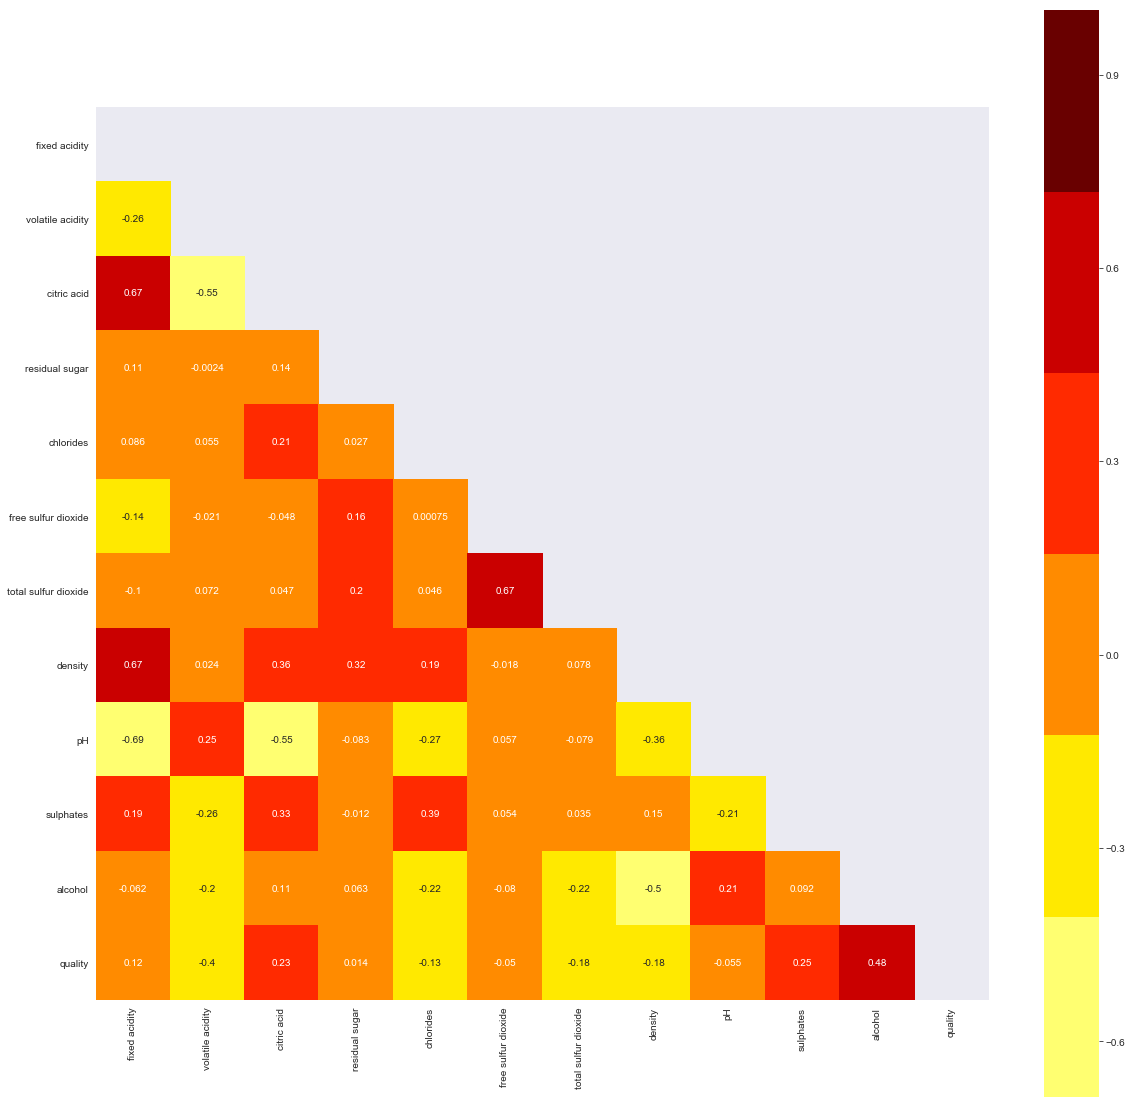

In [28]:
heatmap_corr(df_red)

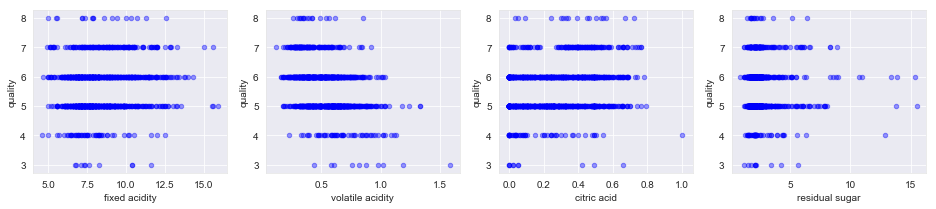

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar'], axes):
    df_red.plot(kind='scatter', x=xcol, y='quality', ax=ax, alpha=0.4, color='b')

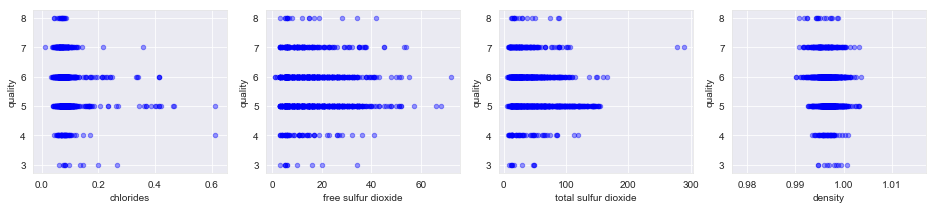

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'], axes):
    df_red.plot(kind='scatter', x=xcol, y='quality', ax=ax, alpha=0.4, color='b')

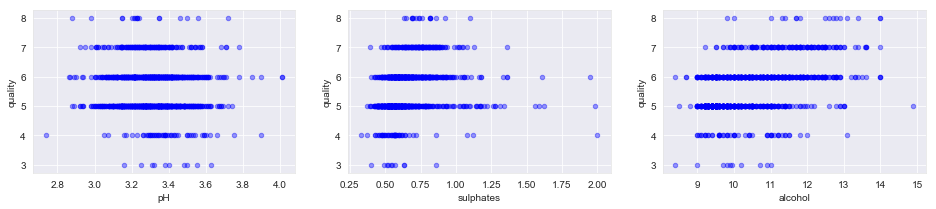

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['pH', 'sulphates', 'alcohol'], axes):
    df_red.plot(kind='scatter', x=xcol, y='quality', ax=ax, alpha=0.4, color='b')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


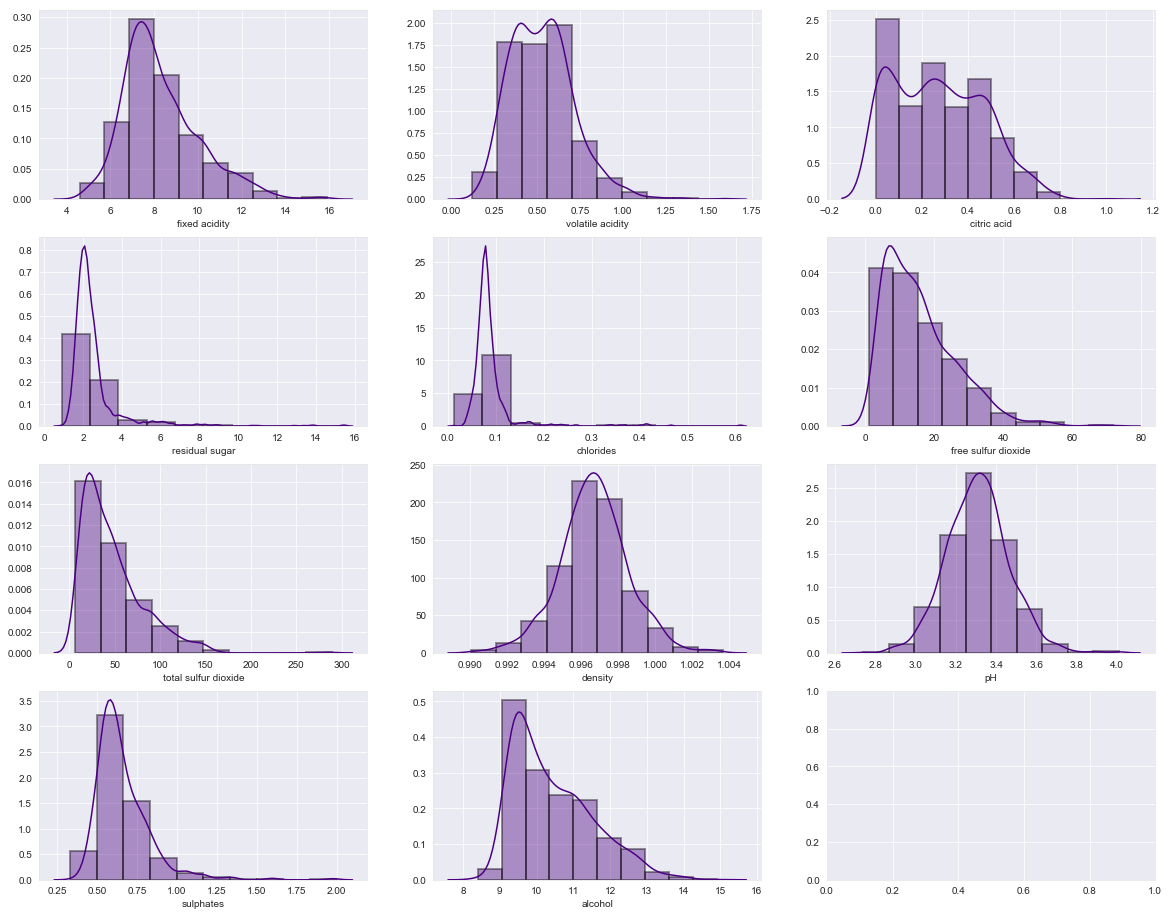

In [32]:
f, ax = plt.subplots(4,3,figsize = (20,16))
plt.rcParams["patch.force_edgecolor"] = True

red_vis1 = sns.distplot(df_red['fixed acidity'],bins=10, color='indigo',hist_kws=dict(edgecolor="k", linewidth=2),ax= ax[0][0])
red_vis2 = sns.distplot(df_red['volatile acidity'],bins=10, color ='indigo',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[0][1])
red_vis3 = sns.distplot(df_red['citric acid'],bins=10, color='indigo',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[0][2])
red_vis4 = sns.distplot(df_red['residual sugar'],bins=10,color='indigo',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[1][0])
red_vis5 = sns.distplot(df_red['chlorides'],bins=10,color='indigo',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[1][1])
red_vis6 = sns.distplot(df_red['free sulfur dioxide'],bins=10,color='indigo', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[1][2])
red_vis7 = sns.distplot(df_red['total sulfur dioxide'],bins=10, color='indigo',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[2][0])
red_vis8 = sns.distplot(df_red['density'],bins=10,color='indigo', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[2][1])
red_vis9 = sns.distplot(df_red['pH'],bins=10,color='indigo', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[2][2])
red_vis10 = sns.distplot(df_red['sulphates'],bins=10,color='indigo', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[3][0])
red_vis11 = sns.distplot(df_red['alcohol'],bins=10,color='indigo', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[3][1])

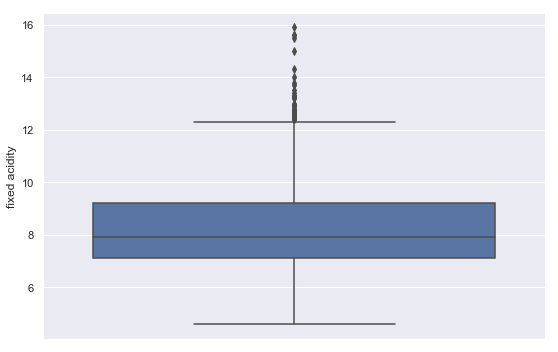

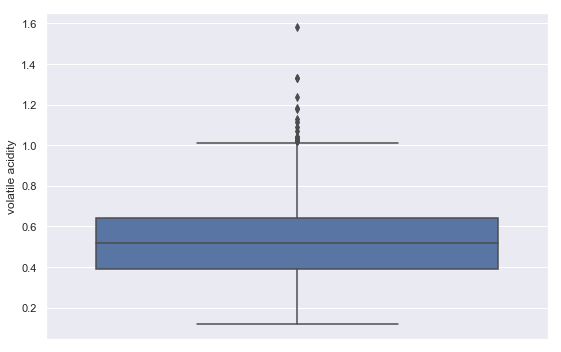

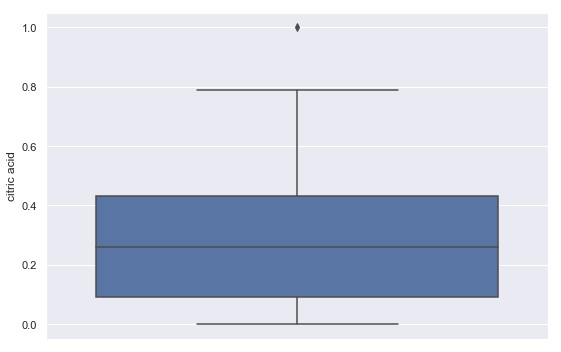

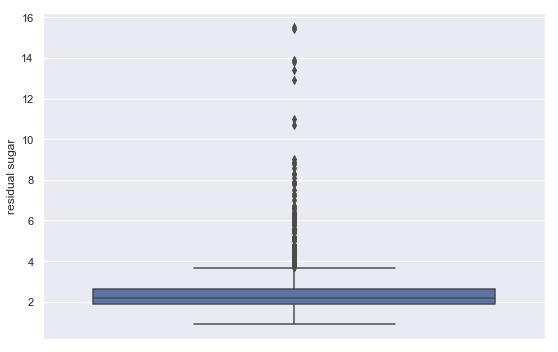

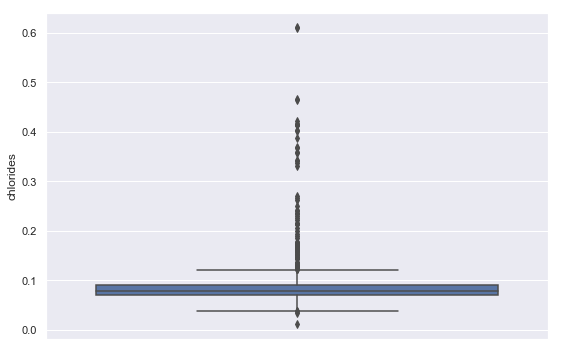

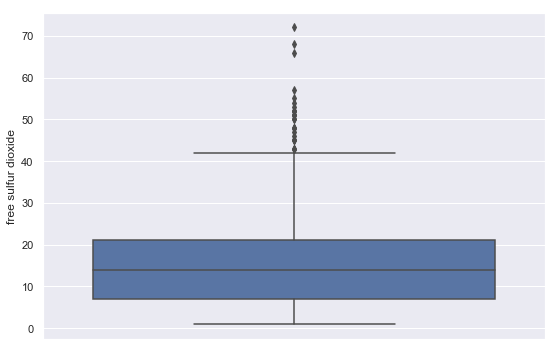

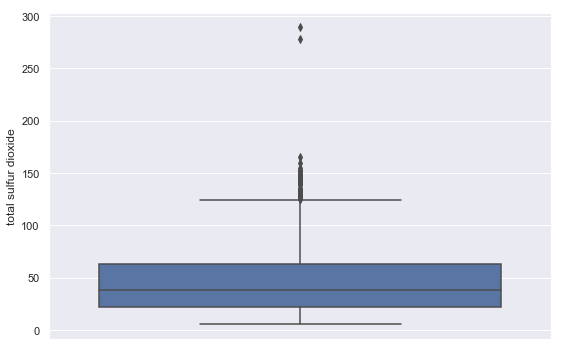

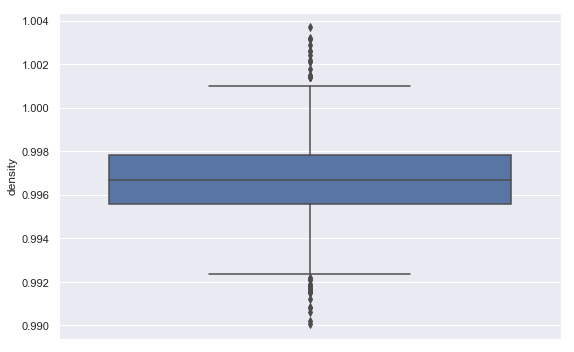

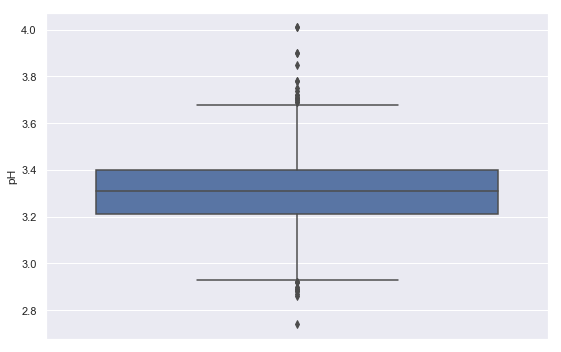

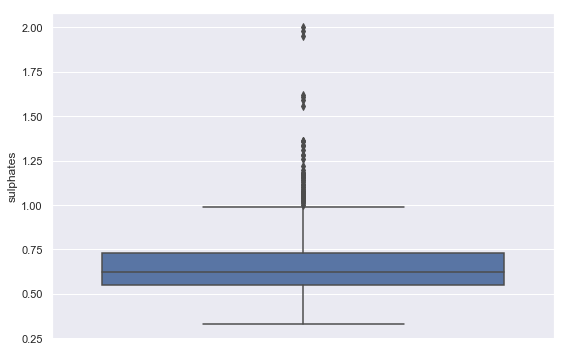

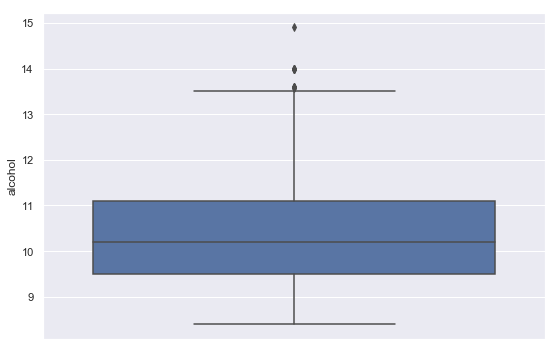

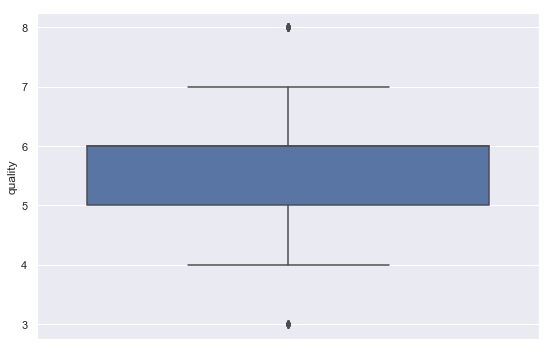

In [33]:
sns.set(rc={'figure.figsize':(9,6)})
for col in df_red:
    ax = sns.boxplot(df_red[col], orient='v')
    plt.show()

In [34]:
df_red = df_red[df_red['volatile acidity'] < 1.4]
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


In [35]:
df_red = df_red[df_red['citric acid'] < 0.85]
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1357 non-null float64
volatile acidity        1357 non-null float64
citric acid             1357 non-null float64
residual sugar          1357 non-null float64
chlorides               1357 non-null float64
free sulfur dioxide     1357 non-null float64
total sulfur dioxide    1357 non-null float64
density                 1357 non-null float64
pH                      1357 non-null float64
sulphates               1357 non-null float64
alcohol                 1357 non-null float64
quality                 1357 non-null int64
dtypes: float64(11), int64(1)
memory usage: 137.8 KB


In [36]:
df_red = df_red[df_red['chlorides'] < .5]
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1356 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1356 non-null float64
volatile acidity        1356 non-null float64
citric acid             1356 non-null float64
residual sugar          1356 non-null float64
chlorides               1356 non-null float64
free sulfur dioxide     1356 non-null float64
total sulfur dioxide    1356 non-null float64
density                 1356 non-null float64
pH                      1356 non-null float64
sulphates               1356 non-null float64
alcohol                 1356 non-null float64
quality                 1356 non-null int64
dtypes: float64(11), int64(1)
memory usage: 137.7 KB


In [37]:
df_red = df_red[df_red['total sulfur dioxide'] < 250]
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1354 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1354 non-null float64
volatile acidity        1354 non-null float64
citric acid             1354 non-null float64
residual sugar          1354 non-null float64
chlorides               1354 non-null float64
free sulfur dioxide     1354 non-null float64
total sulfur dioxide    1354 non-null float64
density                 1354 non-null float64
pH                      1354 non-null float64
sulphates               1354 non-null float64
alcohol                 1354 non-null float64
quality                 1354 non-null int64
dtypes: float64(11), int64(1)
memory usage: 137.5 KB


In [38]:
df_red = df_red[df_red['sulphates'] < 1.4]
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1348 non-null float64
volatile acidity        1348 non-null float64
citric acid             1348 non-null float64
residual sugar          1348 non-null float64
chlorides               1348 non-null float64
free sulfur dioxide     1348 non-null float64
total sulfur dioxide    1348 non-null float64
density                 1348 non-null float64
pH                      1348 non-null float64
sulphates               1348 non-null float64
alcohol                 1348 non-null float64
quality                 1348 non-null int64
dtypes: float64(11), int64(1)
memory usage: 136.9 KB


In [39]:
df_red = df_red[df_red['alcohol'] < 14.5]
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1347 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1347 non-null float64
volatile acidity        1347 non-null float64
citric acid             1347 non-null float64
residual sugar          1347 non-null float64
chlorides               1347 non-null float64
free sulfur dioxide     1347 non-null float64
total sulfur dioxide    1347 non-null float64
density                 1347 non-null float64
pH                      1347 non-null float64
sulphates               1347 non-null float64
alcohol                 1347 non-null float64
quality                 1347 non-null int64
dtypes: float64(11), int64(1)
memory usage: 136.8 KB


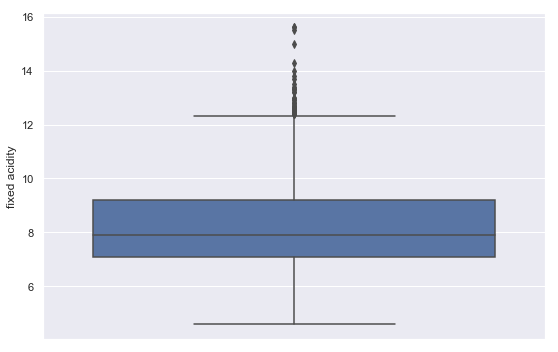

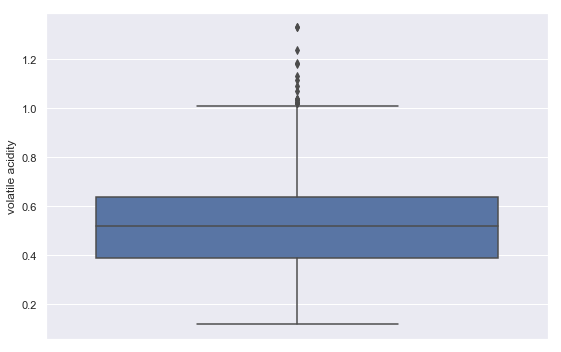

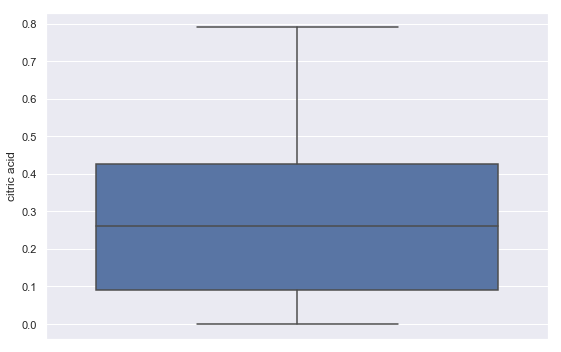

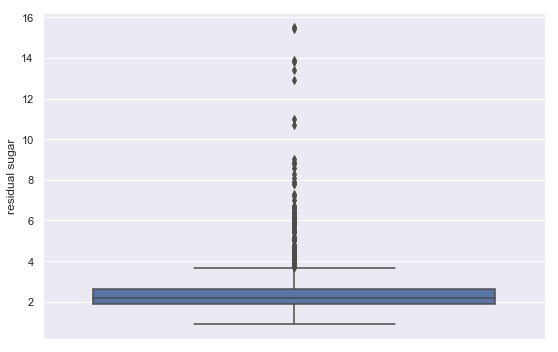

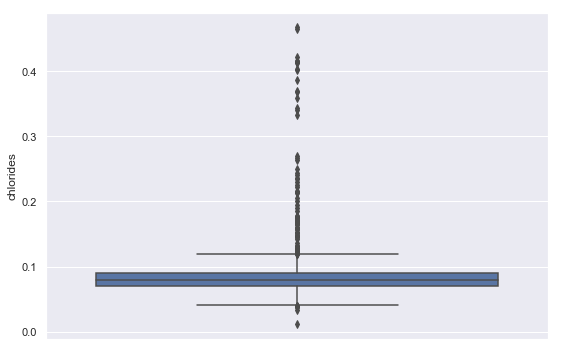

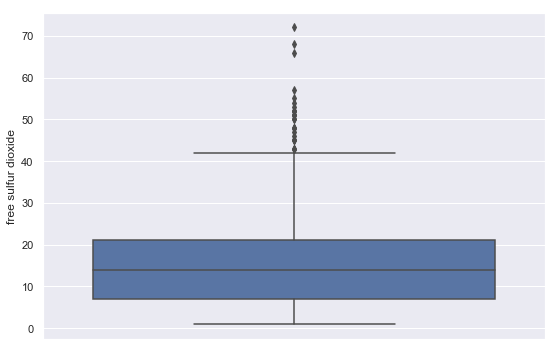

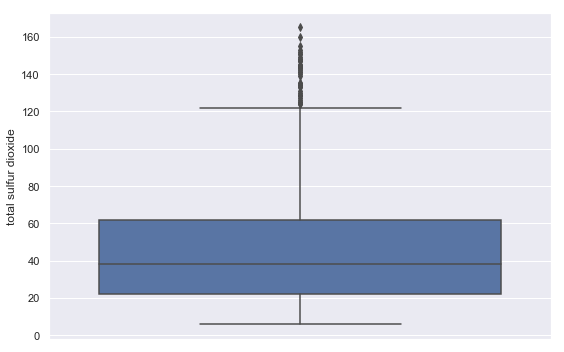

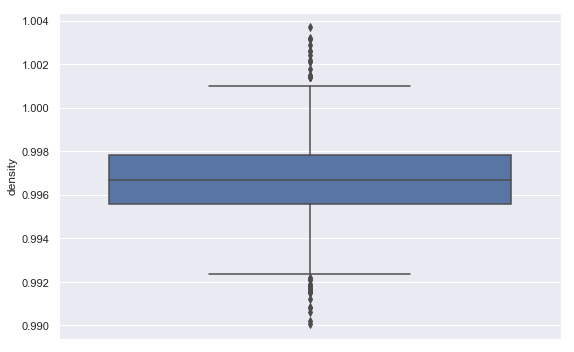

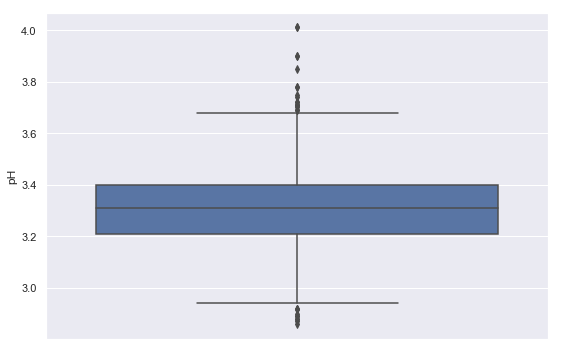

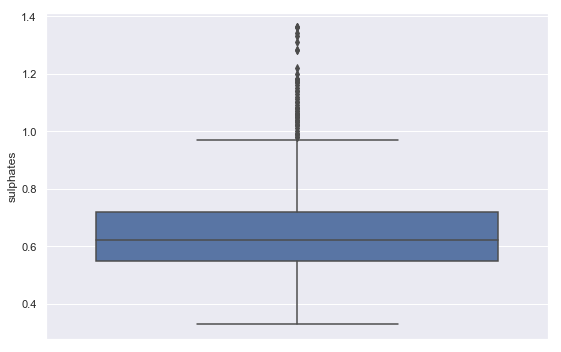

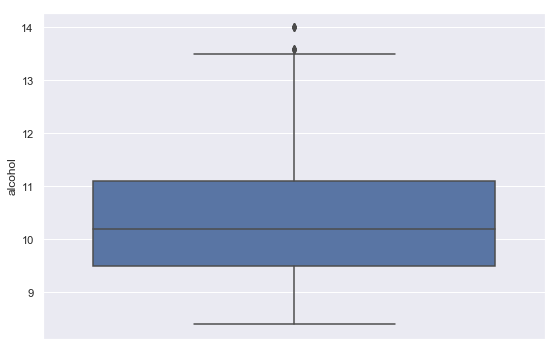

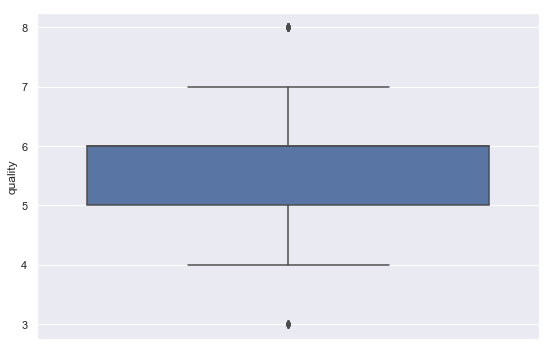

In [40]:
sns.set(rc={'figure.figsize':(9,6)})
for col in df_red:
    ax = sns.boxplot(df_red[col], orient='v')
    plt.show()

### 2.3 White wine exploration/cleaning

In [41]:
df_white.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.300,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.280,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.230,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.230,0.32,8.50,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.280,0.40,6.90,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.320,0.16,7.00,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.270,0.36,20.70,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.300,0.34,1.60,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.220,0.43,1.50,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [42]:
df_white.duplicated().sum()

937

In [43]:
df_white.drop_duplicates(inplace=True)

In [44]:
df_white.duplicated().sum()

0

In [45]:
df_white.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [46]:
df_white.loc[df_white.quality < 5].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,7.193064,0.376503,0.308786,4.718208,0.050549,26.618497,129.500000,0.994278,3.185665,0.476416,10.214740,3.884393
std,1.192788,0.172847,0.156785,4.283510,0.029455,31.625288,63.494483,0.002519,0.171912,0.119592,1.035994,0.320681
min,4.200000,0.110000,0.000000,0.700000,0.013000,3.000000,10.000000,0.989200,2.830000,0.250000,8.000000,3.000000
25%,6.400000,0.260000,0.210000,1.300000,0.037000,9.000000,85.000000,0.992460,3.060000,0.380000,9.400000,4.000000
50%,6.900000,0.320000,0.300000,2.500000,0.046000,18.000000,117.000000,0.994000,3.160000,0.460000,10.100000,4.000000
75%,7.900000,0.470000,0.400000,7.100000,0.054000,33.000000,177.000000,0.996000,3.290000,0.540000,10.900000,4.000000
max,11.800000,1.100000,0.880000,17.550000,0.290000,289.000000,440.000000,1.000400,3.720000,0.870000,13.500000,4.000000


In [47]:
df_white.loc[df_white.quality >= 5].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000,3788.000000
mean,6.823192,0.276155,0.335499,5.969469,0.045693,35.266895,137.544879,0.993767,3.195905,0.490987,10.606467,5.944826
std,0.845682,0.096908,0.120542,4.879916,0.022753,16.156174,41.942302,0.002919,0.150560,0.113214,1.222085,0.799635
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,5.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.375000,107.000000,0.991600,3.100000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.800000,0.042000,34.000000,133.000000,0.993400,3.180000,0.480000,10.500000,6.000000
75%,7.300000,0.320000,0.390000,8.900000,0.050000,46.000000,166.000000,0.995700,3.290000,0.550000,11.408333,6.000000
max,14.200000,0.965000,1.660000,65.800000,0.346000,131.000000,344.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [48]:
df_white['quality'].value_counts()

6    1788
5    1175
7     689
4     153
8     131
3      20
9       5
Name: quality, dtype: int64

In [49]:
df_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


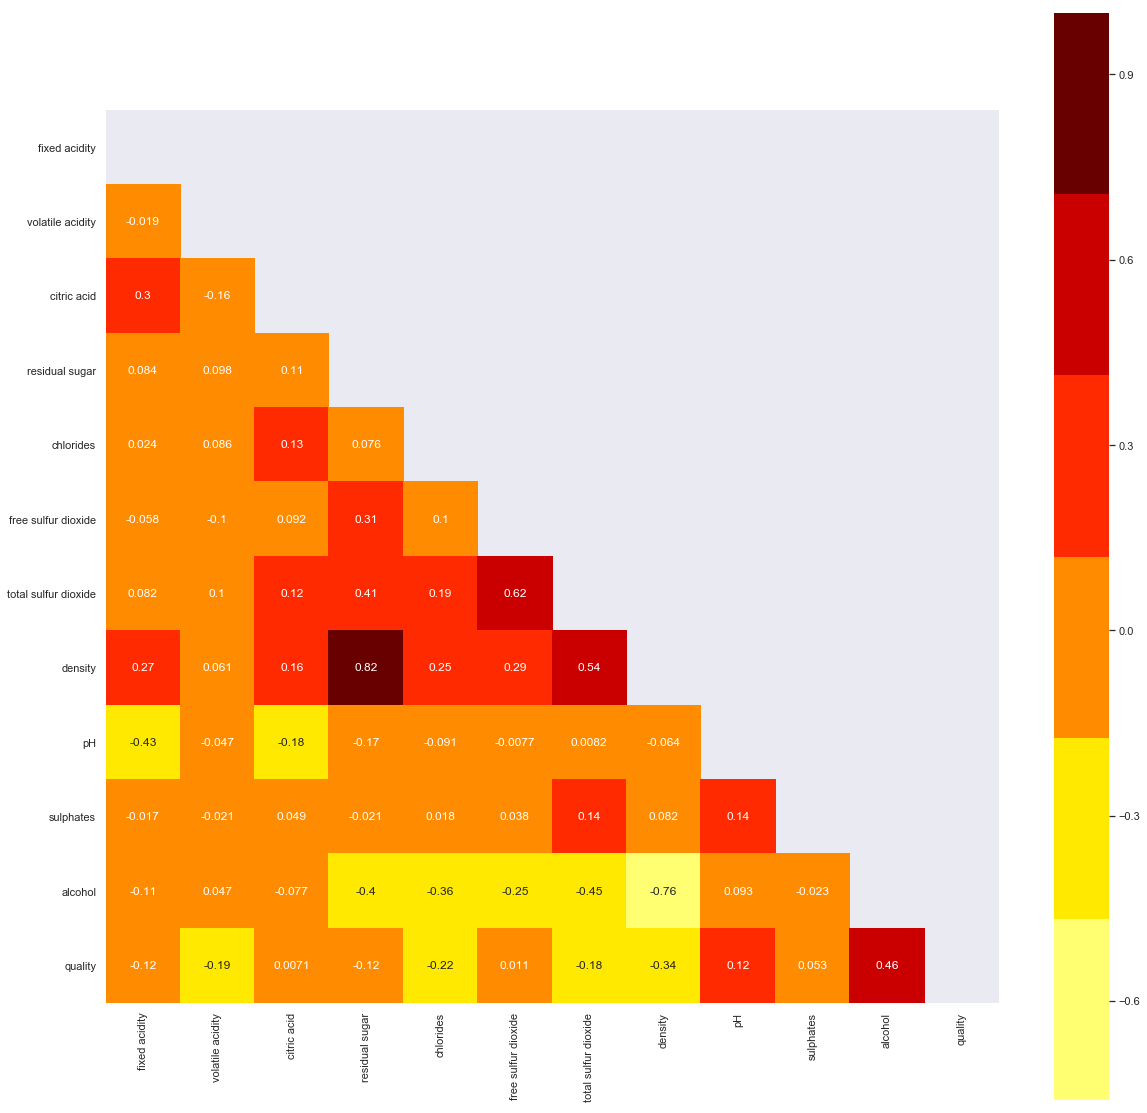

In [50]:
heatmap_corr(df_white)

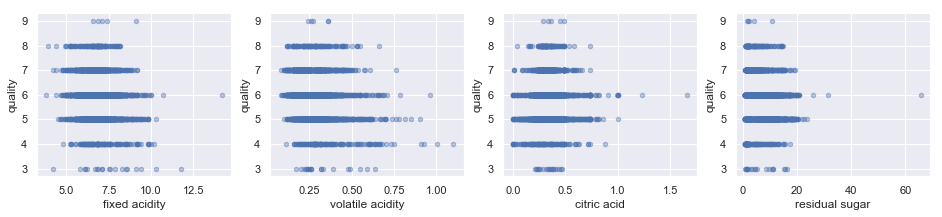

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar'], axes):
    df_white.plot(kind='scatter', x=xcol, y='quality', ax=ax, alpha=0.4, color='b')

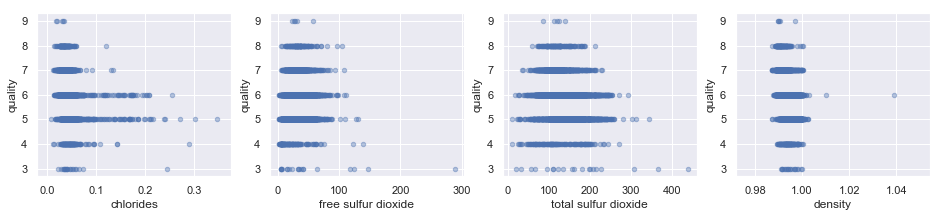

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'], axes):
    df_white.plot(kind='scatter', x=xcol, y='quality', ax=ax, alpha=0.4, color='b')

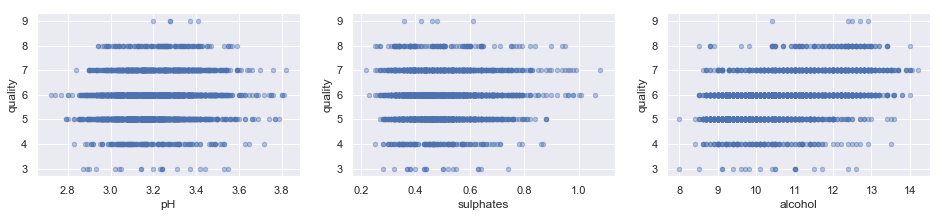

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['pH', 'sulphates', 'alcohol'], axes):
    df_white.plot(kind='scatter', x=xcol, y='quality', ax=ax, alpha=0.4, color='b')

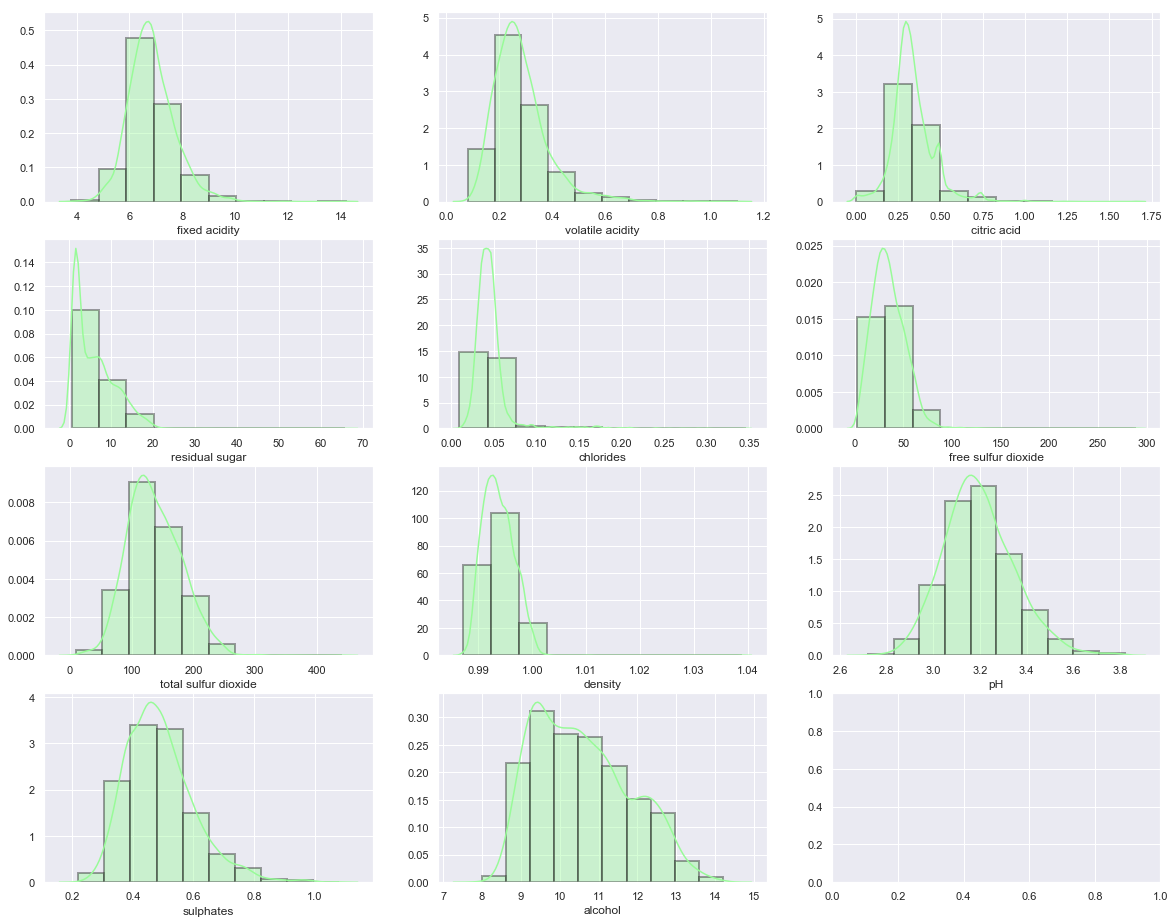

In [54]:
f, ax = plt.subplots(4,3,figsize = (20,16))
plt.rcParams["patch.force_edgecolor"] = True

white_vis1 = sns.distplot(df_white['fixed acidity'],bins=10, color='palegreen',hist_kws=dict(edgecolor="k", linewidth=2),ax= ax[0][0])
white_vis2 = sns.distplot(df_white['volatile acidity'],bins=10, color ='palegreen',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[0][1])
white_vis3 = sns.distplot(df_white['citric acid'],bins=10, color='palegreen',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[0][2])
white_vis4 = sns.distplot(df_white['residual sugar'],bins=10,color='palegreen',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[1][0])
white_vis5 = sns.distplot(df_white['chlorides'],bins=10,color='palegreen',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[1][1])
white_vis6 = sns.distplot(df_white['free sulfur dioxide'],bins=10,color='palegreen', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[1][2])
white_vis7 = sns.distplot(df_white['total sulfur dioxide'],bins=10, color='palegreen',hist_kws=dict(edgecolor="k", linewidth=2), ax=ax[2][0])
white_vis8 = sns.distplot(df_white['density'],bins=10,color='palegreen', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[2][1])
white_vis9 = sns.distplot(df_white['pH'],bins=10,color='palegreen', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[2][2])
white_vis10 = sns.distplot(df_white['sulphates'],bins=10,color='palegreen', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[3][0])
white_vis11 = sns.distplot(df_white['alcohol'],bins=10,color='palegreen', hist_kws=dict(edgecolor="k", linewidth=2),ax=ax[3][1])

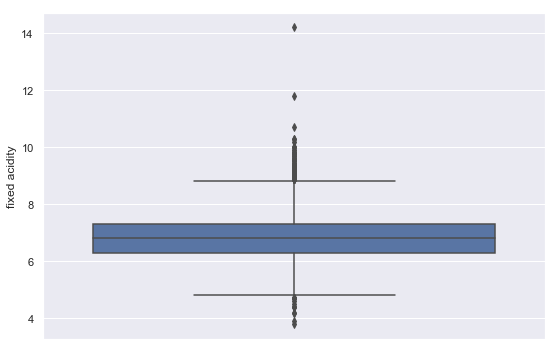

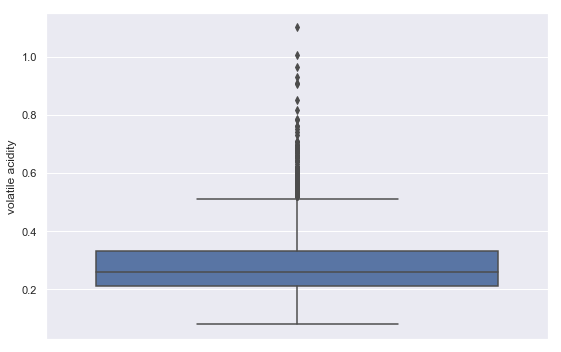

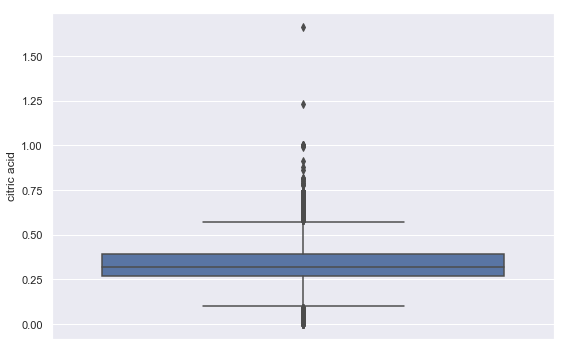

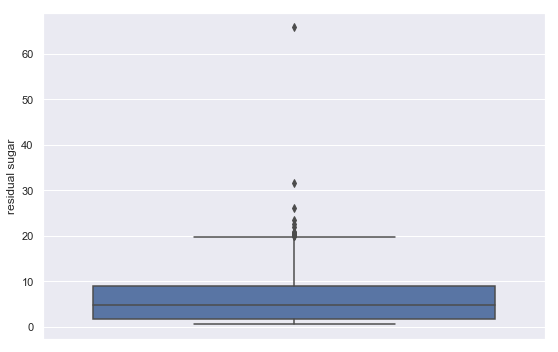

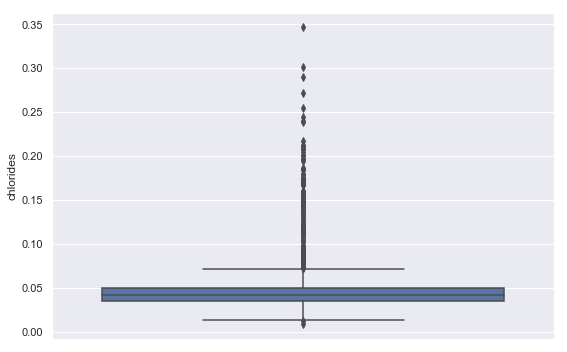

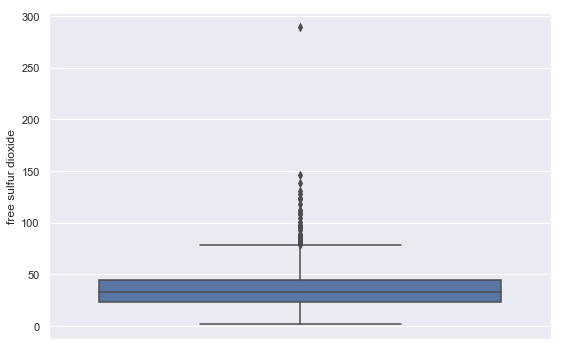

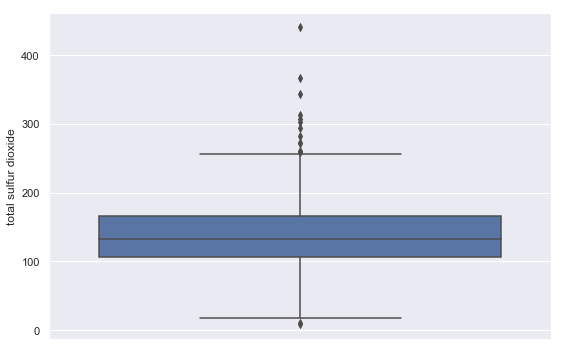

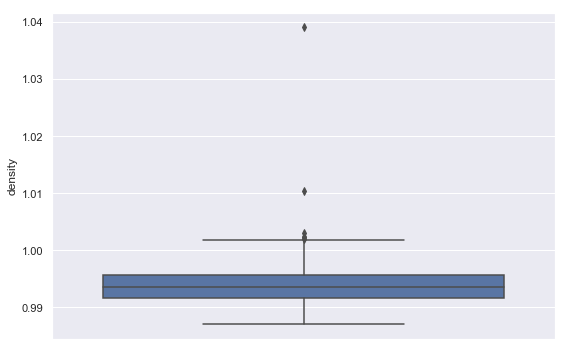

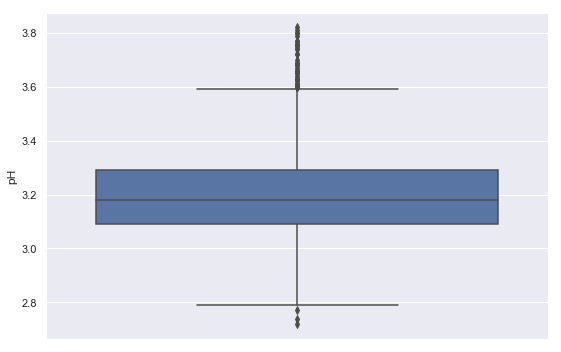

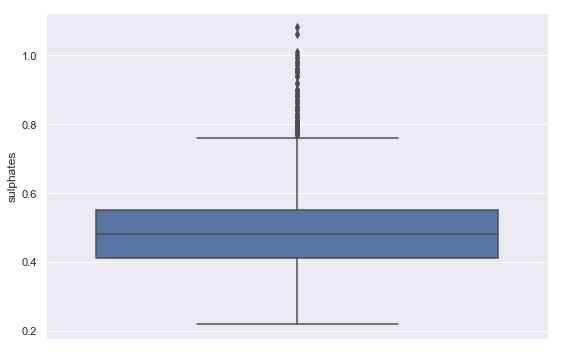

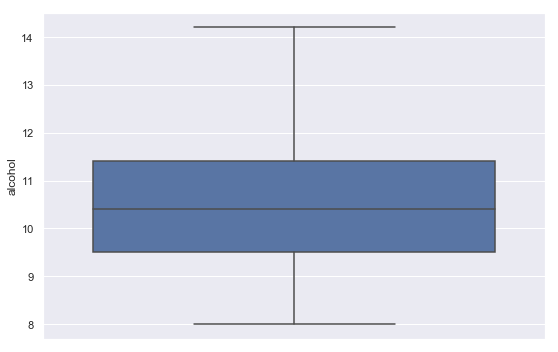

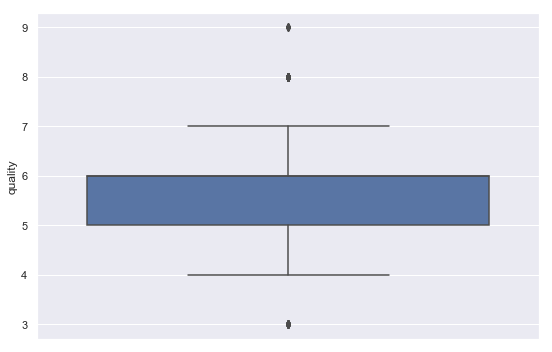

In [56]:
sns.set(rc={'figure.figsize':(9,6)})
for col in df_white:
    ax = sns.boxplot(df_white[col], orient='v')
    plt.show()

In [58]:
df_white = df_white[df_white['fixed acidity'] < 11]
df_white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3959 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           3959 non-null float64
volatile acidity        3959 non-null float64
citric acid             3959 non-null float64
residual sugar          3959 non-null float64
chlorides               3959 non-null float64
free sulfur dioxide     3959 non-null float64
total sulfur dioxide    3959 non-null float64
density                 3959 non-null float64
pH                      3959 non-null float64
sulphates               3959 non-null float64
alcohol                 3959 non-null float64
quality                 3959 non-null int64
dtypes: float64(11), int64(1)
memory usage: 402.1 KB


In [59]:
df_white = df_white[df_white['citric acid'] < 1.15]
df_white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3957 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           3957 non-null float64
volatile acidity        3957 non-null float64
citric acid             3957 non-null float64
residual sugar          3957 non-null float64
chlorides               3957 non-null float64
free sulfur dioxide     3957 non-null float64
total sulfur dioxide    3957 non-null float64
density                 3957 non-null float64
pH                      3957 non-null float64
sulphates               3957 non-null float64
alcohol                 3957 non-null float64
quality                 3957 non-null int64
dtypes: float64(11), int64(1)
memory usage: 401.9 KB


In [60]:
df_white = df_white[df_white['residual sugar'] < 35]
df_white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3956 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           3956 non-null float64
volatile acidity        3956 non-null float64
citric acid             3956 non-null float64
residual sugar          3956 non-null float64
chlorides               3956 non-null float64
free sulfur dioxide     3956 non-null float64
total sulfur dioxide    3956 non-null float64
density                 3956 non-null float64
pH                      3956 non-null float64
sulphates               3956 non-null float64
alcohol                 3956 non-null float64
quality                 3956 non-null int64
dtypes: float64(11), int64(1)
memory usage: 401.8 KB


In [61]:
df_white = df_white[df_white['free sulfur dioxide'] < 150]
df_white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           3955 non-null float64
volatile acidity        3955 non-null float64
citric acid             3955 non-null float64
residual sugar          3955 non-null float64
chlorides               3955 non-null float64
free sulfur dioxide     3955 non-null float64
total sulfur dioxide    3955 non-null float64
density                 3955 non-null float64
pH                      3955 non-null float64
sulphates               3955 non-null float64
alcohol                 3955 non-null float64
quality                 3955 non-null int64
dtypes: float64(11), int64(1)
memory usage: 401.7 KB


In [62]:
df_white = df_white[df_white['total sulfur dioxide'] < 400]
df_white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           3955 non-null float64
volatile acidity        3955 non-null float64
citric acid             3955 non-null float64
residual sugar          3955 non-null float64
chlorides               3955 non-null float64
free sulfur dioxide     3955 non-null float64
total sulfur dioxide    3955 non-null float64
density                 3955 non-null float64
pH                      3955 non-null float64
sulphates               3955 non-null float64
alcohol                 3955 non-null float64
quality                 3955 non-null int64
dtypes: float64(11), int64(1)
memory usage: 401.7 KB


In [63]:
df_white = df_white[df_white['density'] < 1.01]
df_white.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3954 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           3954 non-null float64
volatile acidity        3954 non-null float64
citric acid             3954 non-null float64
residual sugar          3954 non-null float64
chlorides               3954 non-null float64
free sulfur dioxide     3954 non-null float64
total sulfur dioxide    3954 non-null float64
density                 3954 non-null float64
pH                      3954 non-null float64
sulphates               3954 non-null float64
alcohol                 3954 non-null float64
quality                 3954 non-null int64
dtypes: float64(11), int64(1)
memory usage: 401.6 KB


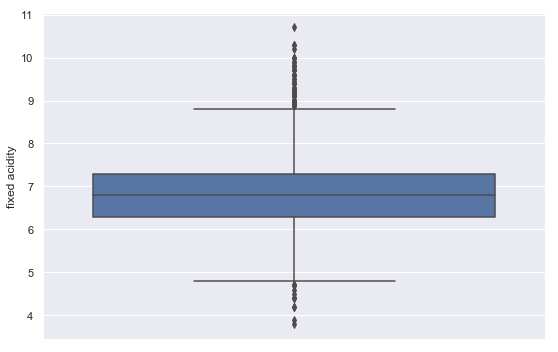

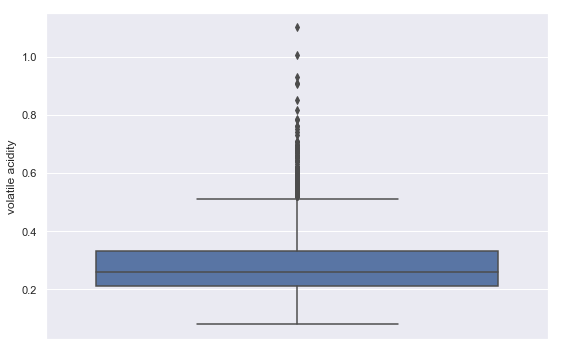

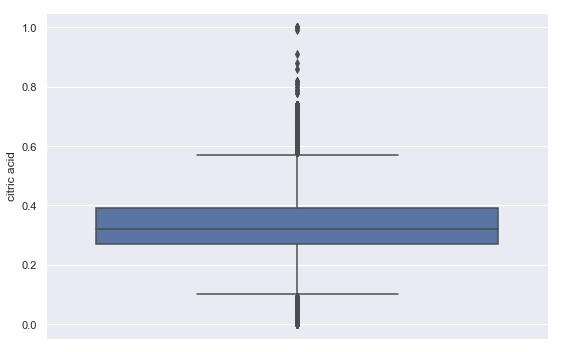

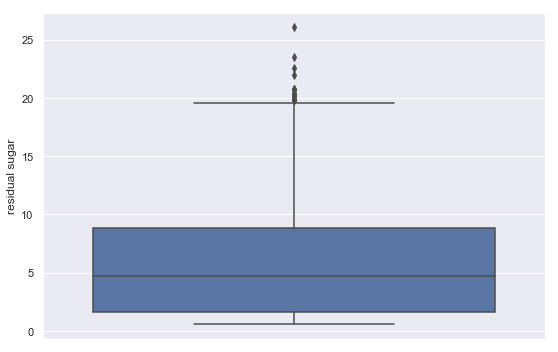

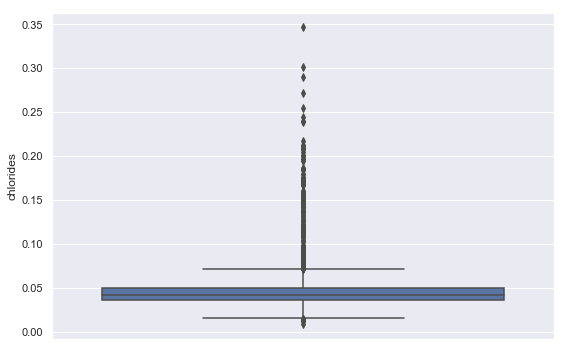

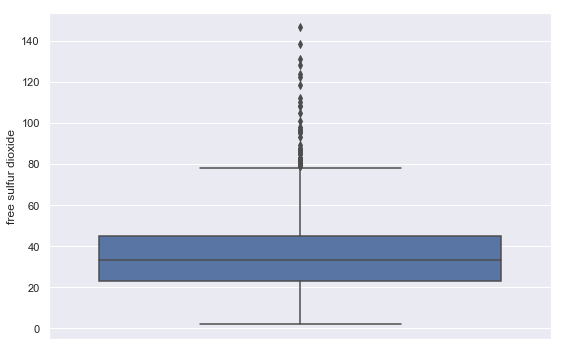

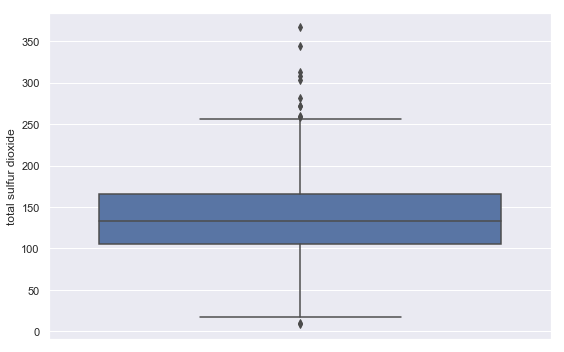

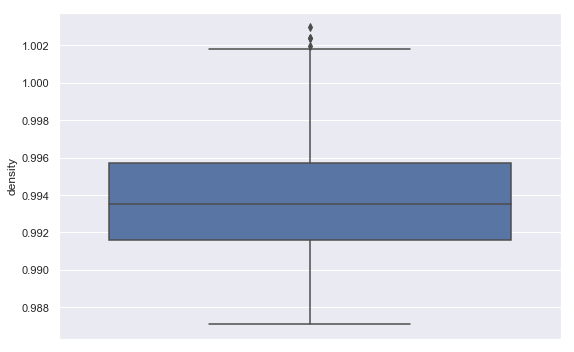

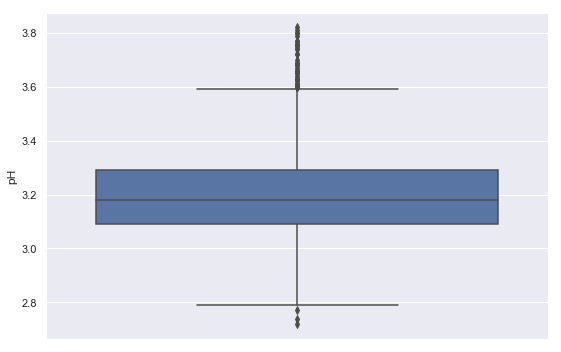

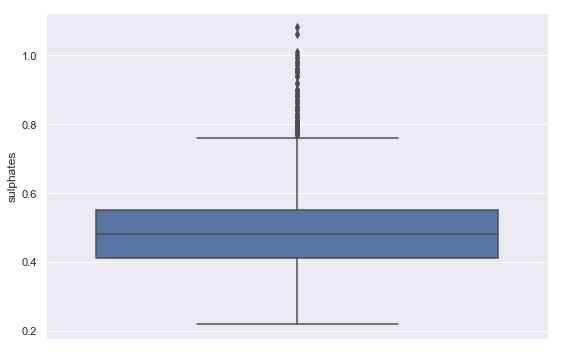

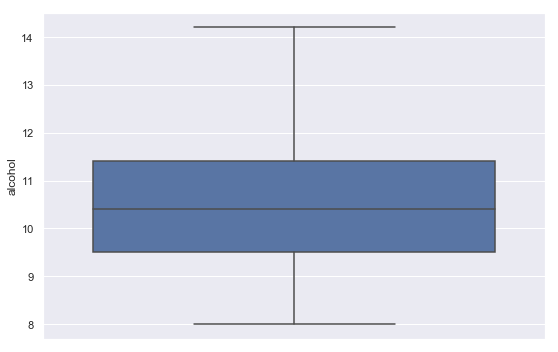

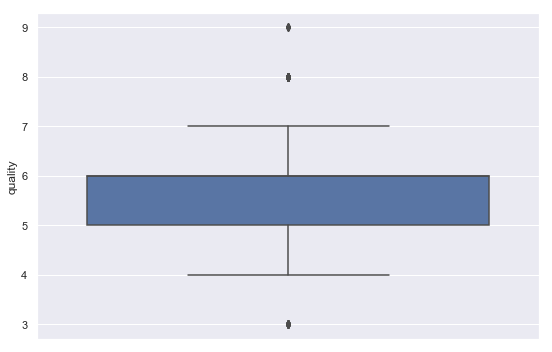

In [64]:
sns.set(rc={'figure.figsize':(9,6)})
for col in df_white:
    ax = sns.boxplot(df_white[col], orient='v')
    plt.show()

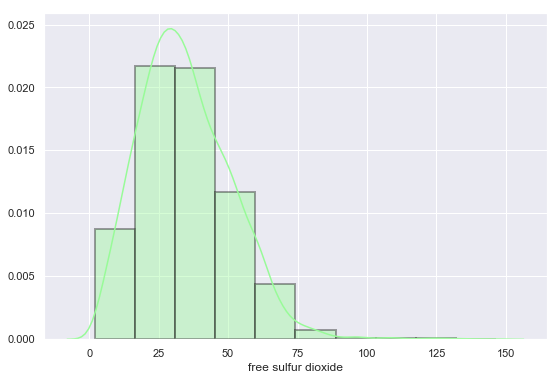

In [65]:
# f, ax = plt.subplots(4,3,figsize = (20,16))
plt.rcParams["patch.force_edgecolor"] = True


sns.distplot(df_white['free sulfur dioxide'],bins=10,color='palegreen', hist_kws=dict(edgecolor="k", linewidth=2))
                                


### 2.4 Creating target variable

In [66]:
df_red['bad_wine'] = [1 if x < 5 else 0 for x in df_red['quality']]
df_red['bad_wine'].value_counts()

0    1286
1      61
Name: bad_wine, dtype: int64

In [67]:
df_red.drop(['quality'], axis=1, inplace=True)

In [68]:
df_white['bad_wine'] = [1 if x < 5 else 0 for x in df_white['quality']]
df_white['bad_wine'].value_counts()

0    3783
1     171
Name: bad_wine, dtype: int64

In [69]:
df_white.drop(['quality'], axis=1, inplace=True)

In [70]:
df_white.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'bad_wine'],
      dtype='object')

In [71]:
df_red.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'bad_wine'],
      dtype='object')

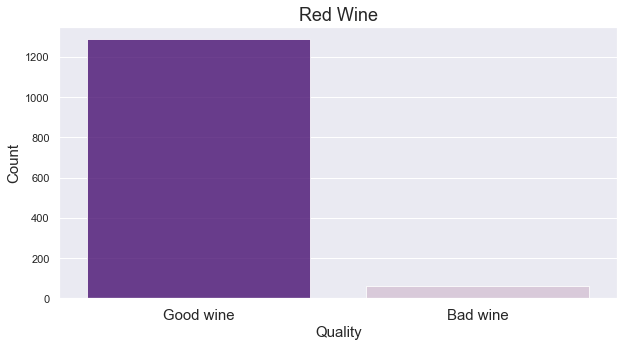

In [74]:
plt.figure(figsize = (10,5))
ax = sns.countplot(df_red['bad_wine'], alpha =.80, palette= ['indigo','thistle'], order=[0, 1])
ax.set_xticklabels({'Good wine','Bad wine'}, fontsize=15)
plt.title('Red Wine', fontsize=18)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Quality', fontsize=15)
plt.show()

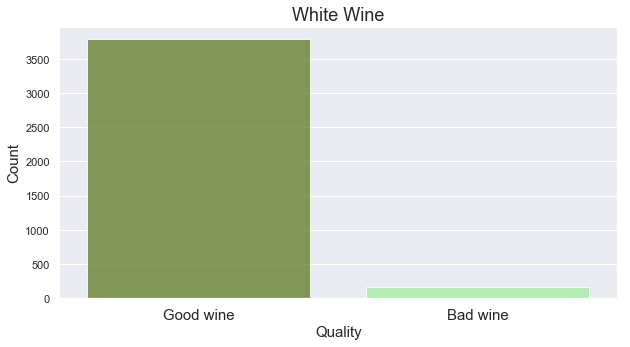

In [76]:
plt.figure(figsize = (10,5))
ax= sns.countplot(df_white['bad_wine'], alpha =.80, palette= ['olivedrab','palegreen'],order=[0, 1])
ax.set_xticklabels({'Good wine','Bad wine'}, fontsize=15)
plt.title('White Wine', fontsize=18)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Quality', fontsize=15)
plt.show()

## 3. Baseline Model Test

### 3.1 Red Wine Baseline w/ Logistic Regression

In [77]:
red_baseline_features = df_red.drop(['bad_wine'],axis=1)
red_baseline_target = df_red['bad_wine']

In [78]:
redBase_X_train, redBase_X_test, redBase_y_train, redBase_y_test = train_test_split(red_baseline_features, red_baseline_target, random_state=34,test_size=0.2)

redBase_scaler = StandardScaler()  
redBase_scaler.fit(redBase_X_train)

redBase_X_train = pd.DataFrame(redBase_scaler.transform(redBase_X_train), columns=redBase_X_train.columns)  
redBase_X_test = pd.DataFrame(redBase_scaler.transform(redBase_X_test), columns=redBase_X_test.columns)


In [79]:
redBase_y_red_class = logiRegr(redBase_X_train, redBase_X_test, redBase_y_train, redBase_y_test)

Classification Accuracy:  0.9481481481481482
Test F1 score:  0.0


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [96]:
print(metrics.recall_score(redBase_y_test, redBase_y_red_class))

0.0


### 3.2 White Wine Baseline w/ Logistic Regression

In [97]:
white_baseline_features = df_white.drop(['bad_wine'],axis=1)
white_baseline_target = df_white['bad_wine']

In [98]:
whiteBase_X_train, whiteBase_X_test, whiteBase_y_train, whiteBase_y_test = train_test_split(white_baseline_features, white_baseline_target, random_state=34,test_size=0.2)

whiteBase_scaler = StandardScaler()  
whiteBase_scaler.fit(whiteBase_X_train)

whiteBase_X_train = pd.DataFrame(whiteBase_scaler.transform(whiteBase_X_train), columns=whiteBase_X_train.columns)  
whiteBase_X_test = pd.DataFrame(whiteBase_scaler.transform(whiteBase_X_test), columns=whiteBase_X_test.columns)

In [99]:
whiteBase_y_pred_class = logiRegr(whiteBase_X_train, whiteBase_X_test, whiteBase_y_train, whiteBase_y_test)

Classification Accuracy:  0.9608091024020228
Test F1 score:  0.0606060606060606


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [100]:
print(metrics.recall_score(whiteBase_y_test, whiteBase_y_pred_class))

0.03333333333333333


As is probably to be expected, high accuracy but low F1. 

## 4. Feature Engineering

- Can I infer color from acidity levels?
- Total acidity is fixed acidity + volatile acidity. 
- The amount of Free SO2 needed to maintain the bacterial stability of wine changes as the pH changes, so make an interaction variable for that. 
- High amounts of free SO2 can negatively impact the taste of the wine. 
- Relationship between bound SO2 and pH. 

Need more sulfides:
- Higher pH
- Red needs more than white
- Higher residual sugars
- More citric acid = higher free SO2 and lower bound SO2 

#### Bound SO2 - Red

In [101]:
df_red['bound_SO2'] = df_red['total sulfur dioxide'] - df_red['free sulfur dioxide']
df_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,bad_wine,bound_SO2
count,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000,1347.000000
mean,8.306904,0.529246,0.270549,2.514031,0.086950,15.835932,46.255754,0.996712,3.312249,0.652821,10.431341,0.045286,30.419822
std,1.731353,0.181109,0.193788,1.331952,0.044113,10.422046,31.986614,0.001869,0.152554,0.149991,1.075073,0.208008,26.125417
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,0.000000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,0.000000,12.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,0.000000,21.000000
75%,9.200000,0.640000,0.425000,2.600000,0.090000,21.000000,62.000000,0.997830,3.400000,0.720000,11.100000,0.000000,39.000000
max,15.600000,1.330000,0.790000,15.500000,0.467000,72.000000,165.000000,1.003690,4.010000,1.360000,14.000000,1.000000,128.000000


#### Adjusted Free SO2 - Red

In [102]:
df_red['adjusted_free_SO2'] = df_red['free sulfur dioxide'] - (df_red['citric acid'] + df_red['pH'] + df_red['residual sugar'])


In [103]:
df_red.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,bad_wine,bound_SO2,adjusted_free_SO2
0,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,23.0,5.59
1,7.8,0.880,0.00,2.60,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,42.0,19.20
2,7.8,0.760,0.04,2.30,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,39.0,9.40
3,11.2,0.280,0.56,1.90,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,43.0,11.38
5,7.4,0.660,0.00,1.80,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0,27.0,7.69
6,7.9,0.600,0.06,1.60,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,0,44.0,10.04
7,7.3,0.650,0.00,1.20,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,0,6.0,10.41
8,7.8,0.580,0.02,2.00,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,0,9.0,3.62
9,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,0,85.0,7.19
10,6.7,0.580,0.08,1.80,0.097,15.0,65.0,0.9959,3.28,0.54,9.2,0,50.0,9.84


#### Binning Alcohol - Red

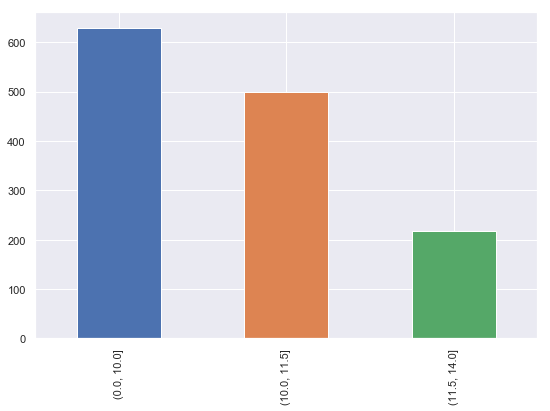

In [104]:
bins = [0, 10, 11.5, 14]
bins_red_alc = pd.cut(df_red['alcohol'], bins)
bins_red_alc = bins_red_alc.cat.as_unordered()
bins_red_alc.value_counts().plot(kind='bar')

In [105]:
df_red['alcohol']=bins_red_alc

In [106]:
red_alc_dummies = pd.get_dummies(df_red['alcohol'], prefix="abv", drop_first=True)
df_red = df_red.drop('alcohol', axis=1)
df_red = pd.concat([df_red, red_alc_dummies], axis=1)

#### Molecular SO2 - Red

In [107]:
df_red['molecular_SO2'] = df_red['free sulfur dioxide'] / (1+10**(df_red['pH']-1.8))

In [108]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,bad_wine,bound_SO2,adjusted_free_SO2,"abv_(10.0, 11.5]","abv_(11.5, 14.0]",molecular_SO2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,0,23.0,5.59,0,0,0.210381
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,0,42.0,19.20,0,0,0.957163
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,0,39.0,9.40,0,0,0.502676
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,0,43.0,11.38,0,0,0.711039
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,0,27.0,7.69,0,0,0.248632


#### Binning pH - Red

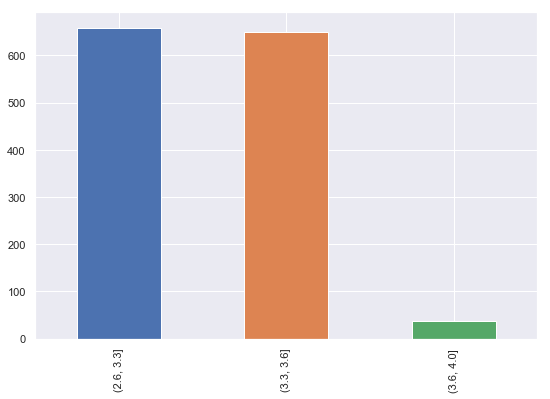

In [109]:
bins_ph = [2.6, 3.3, 3.6, 4]
bins_red_ph = pd.cut(df_red['pH'], bins_ph)
bins_red_ph = bins_red_ph.cat.as_unordered()
bins_red_ph.value_counts().plot(kind='bar')

In [110]:
df_red['pH']=bins_red_ph

In [111]:
red_ph_dummies = pd.get_dummies(df_red['pH'], prefix="pH", drop_first=True)
df_red = df_red.drop('pH', axis=1)
df_red = pd.concat([df_red, red_ph_dummies], axis=1)

#### Bound SO2 - White

In [112]:
df_white['bound_SO2'] = df_white['total sulfur dioxide'] - df_white['free sulfur dioxide']
df_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,bad_wine,bound_SO2
count,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000,3954.000000
mean,6.835572,0.280401,0.333687,5.895144,0.045910,34.833333,137.066641,0.993775,3.195463,0.490263,10.588606,0.043247,102.233308
std,0.855540,0.102939,0.119769,4.752250,0.023114,16.733841,42.815621,0.002802,0.151510,0.113526,1.216658,0.203439,35.100769
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000,4.000000
25%,6.300000,0.210000,0.270000,1.600000,0.036000,23.000000,106.000000,0.991613,3.090000,0.410000,9.500000,0.000000,77.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,0.000000,99.000000
75%,7.300000,0.330000,0.390000,8.800000,0.050000,45.000000,166.000000,0.995700,3.290000,0.550000,11.400000,0.000000,124.000000
max,10.700000,1.100000,1.000000,26.050000,0.346000,146.500000,366.500000,1.002950,3.820000,1.080000,14.200000,1.000000,331.000000


#### Adjusted Free SO2 - White

In [113]:
df_white['adjusted_free_SO2'] = df_white['free sulfur dioxide'] - (df_white['citric acid'] + df_white['pH'] + df_white['residual sugar'])
df_white.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,bad_wine,bound_SO2,adjusted_free_SO2
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,125.0,20.94
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,118.0,8.76
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,67.0,19.44
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,139.0,34.99
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,0,106.0,19.66


#### Alcohol Binning - White

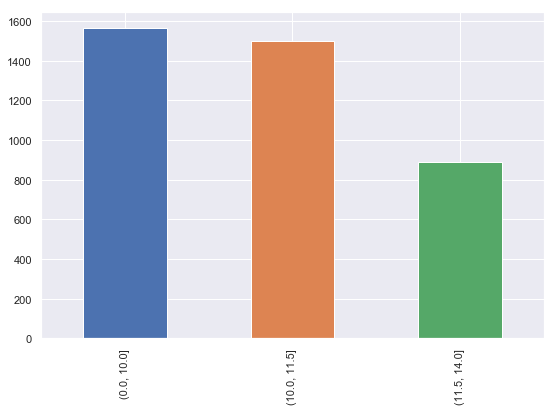

In [114]:
bins_white = [0, 10, 11.5, 14]
bins_white_alc = pd.cut(df_white['alcohol'], bins_white)
bins_white_alc = bins_white_alc.cat.as_unordered()
bins_white_alc.value_counts().plot(kind='bar')

In [115]:
df_white['alcohol']=bins_white_alc

In [116]:
white_alc_dummies = pd.get_dummies(df_white['alcohol'], prefix="abv", drop_first=True)
df_white = df_white.drop('alcohol', axis=1)
df_white = pd.concat([df_white, white_alc_dummies], axis=1)

#### Molecular SO2 - White

In [117]:
df_white['molecular_SO2'] = df_white['free sulfur dioxide'] / (1+10**(df_white['pH']-1.8))

#### Binning pH - White

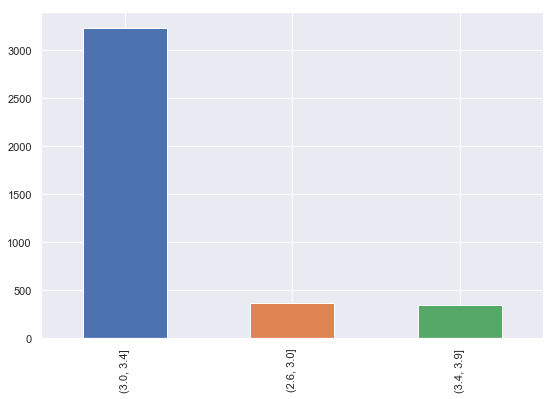

In [118]:
bins_w_ph = [2.6, 3.0, 3.4, 3.9]
bins_white_ph = pd.cut(df_white['pH'], bins_w_ph)
bins_white_ph = bins_white_ph.cat.as_unordered()
bins_white_ph.value_counts().plot(kind='bar')

In [119]:
df_white['pH']=bins_white_ph

In [120]:
white_ph_dummies = pd.get_dummies(df_white['pH'], prefix="pH", drop_first=True)
df_white = df_white.drop('pH', axis=1)
df_white = pd.concat([df_white, white_ph_dummies], axis=1)

## 5. Pre-feature selection/parameter tuning modeling

### 5.1 Train/Test/Split, Scaling, Upsample - Red

In [121]:
red_features = df_red.drop(['bad_wine'],axis=1)
red_target = df_red['bad_wine']

In [122]:
red_X_train, red_X_test, red_y_train, red_y_test = train_test_split(red_features, red_target, random_state=34,test_size=0.2)


In [123]:
red_scaler = StandardScaler()  
red_scaler.fit(red_X_train)

red_X_train_scaled = pd.DataFrame(red_scaler.transform(red_X_train), columns=red_X_train.columns)  
red_X_test_scaled = pd.DataFrame(red_scaler.transform(red_X_test), columns=red_X_test.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


In [817]:
red_X_train_sm,red_y_train_sm = upSampleMinoritySMOTE(red_X_train_scaled, red_y_train)

1183 1183


### 5.1.1 Logistic Regression - Red

In [821]:
red_y_pred_class_lr = logiRegr(red_X_train_sm, red_X_test, red_y_train_sm, red_y_test)

Classification Accuracy:  0.9259259259259259
Test F1 score:  0.0


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [822]:
print(metrics.recall_score(red_y_test, red_y_pred_class_lr))

0.0


### 5.1.1.1 LR Red - Feature Selection

In [780]:
logreg = LogisticRegression()

In [823]:
# Create recursive feature eliminator that scores features by mean squared errors
lr_red_selector = RFECV(estimator=logreg, step=1, cv=5, scoring='recall')

# Fit recursive feature eliminator 
lr_red_selector.fit(red_X_train_scaled, red_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='recall', step=1,
   verbose=0)

In [824]:
selected_columns = red_X_train_scaled.columns[lr_red_selector.support_]
removed_columns = red_X_train_scaled.columns[~lr_red_selector.support_]
list(removed_columns)

['citric acid',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'adjusted_free_SO2',
 'pH_(3.6, 4.0]']

In [825]:
red_X_train_scaled_2 = red_X_train_scaled.drop(['citric acid','chlorides','free sulfur dioxide','total sulfur dioxide','adjusted_free_SO2',], axis=1)
red_X_test_scaled_2 = red_X_test_scaled.drop(['citric acid','chlorides','free sulfur dioxide','total sulfur dioxide','adjusted_free_SO2',], axis=1)



In [827]:
red_X_train_sm_2,red_y_train_sm_2 = upSampleMinoritySMOTE(red_X_train_scaled_2, red_y_train)

1183 1183


In [828]:
red_y_pred_class_lr_2 = logiRegr(red_X_train_sm_2, red_X_test_scaled_2, red_y_train_sm_2, red_y_test)

Classification Accuracy:  0.9296296296296296
Test F1 score:  0.0


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [829]:
print(metrics.recall_score(red_y_test, red_y_pred_class_lr_2))

0.0


### 5.1.2 KNN - Red

In [830]:
red_y_pred_class_knn = knn(3, red_X_train_sm, red_y_train_sm, red_X_test, red_y_test)

Test Accuracy score:  0.9518518518518518
Test F1 score:  0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [831]:
print(metrics.recall_score(red_y_test, red_y_pred_class_knn))

0.0


### 5.1.3 Random Forest - Red

In [832]:
red_rf = RandomForestClassifier(random_state = 23, n_estimators=100)

In [833]:
red_rf.fit(red_X_train_sm, red_y_train_sm)
red_rf_pred = red_rf.predict(red_X_test)

In [834]:
print('Test Accuracy score: ', accuracy_score(red_y_test, red_rf_pred))
print('Test F1 score: ', f1_score(red_y_test, red_rf_pred))
print(metrics.recall_score(red_y_test, red_rf_pred))

Test Accuracy score:  0.9518518518518518
Test F1 score:  0.0
0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### 5.2 Polynomials - Red

In [835]:
red_poly = PolynomialFeatures(degree=2, include_bias=False)
red_poly.fit(red_X_train)
red_X_train_poly= pd.DataFrame(red_poly.transform(red_X_train), columns=red_poly.get_feature_names(red_X_train.columns))
red_X_test_poly= pd.DataFrame(red_poly.transform(red_X_test), columns=red_poly.get_feature_names(red_X_test.columns))
                               
red_columns_poly = red_poly.get_feature_names(red_X_train.columns)

In [836]:
red_poly_scalar = StandardScaler()

red_poly_scalar.fit(red_X_train_poly)
red_X_train_poly_scaled  = pd.DataFrame(red_poly_scalar.transform(red_X_train_poly), columns=red_columns_poly)
red_X_test_poly_scaled  = pd.DataFrame(red_poly_scalar.transform(red_X_test_poly), columns=red_columns_poly)

In [837]:
red_poly_X_train_sm,red_poly_y_train_sm = upSampleMinoritySMOTE(red_X_train_poly_scaled, red_y_train)

1183 1183


### 5.2.1 Polynomial Logistic Regression - Red

In [838]:
red_y_pred_class_poly_lr = logiRegr(red_poly_X_train_sm, red_X_test_poly_scaled, red_poly_y_train_sm, red_y_test)

Classification Accuracy:  0.9259259259259259
Test F1 score:  0.09090909090909093


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [839]:
print(metrics.recall_score(red_y_test, red_y_pred_class_poly_lr))

0.07692307692307693


In [840]:
# Create recursive feature eliminator that scores features by mean squared errors
lr_red_poly_selector = RFECV(estimator=logreg, step=1, cv=5, scoring='recall')

# Fit recursive feature eliminator 
lr_red_poly_selector.fit(red_X_train_poly, red_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='recall', step=1,
   verbose=0)

In [841]:
selected_columns = red_X_train_poly.columns[lr_red_poly_selector.support_]
removed_columns = red_X_train_poly.columns[~lr_red_poly_selector.support_]
list(removed_columns)
list(selected_columns)

['free sulfur dioxide',
 'sulphates',
 'fixed acidity volatile acidity',
 'fixed acidity abv_(10.0, 11.5]',
 'fixed acidity abv_(11.5, 14.0]',
 'volatile acidity^2',
 'volatile acidity abv_(10.0, 11.5]',
 'volatile acidity pH_(3.3, 3.6]',
 'residual sugar abv_(10.0, 11.5]',
 'residual sugar abv_(11.5, 14.0]',
 'chlorides bound_SO2',
 'chlorides adjusted_free_SO2',
 'free sulfur dioxide sulphates',
 'free sulfur dioxide pH_(3.6, 4.0]',
 'density^2',
 'density sulphates',
 'sulphates adjusted_free_SO2',
 'sulphates abv_(10.0, 11.5]',
 'adjusted_free_SO2 pH_(3.6, 4.0]',
 'abv_(10.0, 11.5] molecular_SO2',
 'abv_(11.5, 14.0] pH_(3.3, 3.6]']

In [842]:
list(removed_columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'total sulfur dioxide',
 'density',
 'bound_SO2',
 'adjusted_free_SO2',
 'abv_(10.0, 11.5]',
 'abv_(11.5, 14.0]',
 'molecular_SO2',
 'pH_(3.3, 3.6]',
 'pH_(3.6, 4.0]',
 'fixed acidity^2',
 'fixed acidity citric acid',
 'fixed acidity residual sugar',
 'fixed acidity chlorides',
 'fixed acidity free sulfur dioxide',
 'fixed acidity total sulfur dioxide',
 'fixed acidity density',
 'fixed acidity sulphates',
 'fixed acidity bound_SO2',
 'fixed acidity adjusted_free_SO2',
 'fixed acidity molecular_SO2',
 'fixed acidity pH_(3.3, 3.6]',
 'fixed acidity pH_(3.6, 4.0]',
 'volatile acidity citric acid',
 'volatile acidity residual sugar',
 'volatile acidity chlorides',
 'volatile acidity free sulfur dioxide',
 'volatile acidity total sulfur dioxide',
 'volatile acidity density',
 'volatile acidity sulphates',
 'volatile acidity bound_SO2',
 'volatile acidity adjusted_free_SO2',
 'volatile acidity abv_(11.5

In [843]:
red_X_train_poly_2 = red_X_train_poly[['free sulfur dioxide',
 'sulphates',
 'fixed acidity volatile acidity',
 'fixed acidity abv_(10.0, 11.5]',
 'fixed acidity abv_(11.5, 14.0]',
 'volatile acidity^2',
 'volatile acidity abv_(10.0, 11.5]',
 'volatile acidity pH_(3.3, 3.6]',
 'residual sugar abv_(10.0, 11.5]',
 'residual sugar abv_(11.5, 14.0]',
 'chlorides bound_SO2',
 'chlorides adjusted_free_SO2',
 'free sulfur dioxide sulphates',
 'free sulfur dioxide pH_(3.6, 4.0]',
 'density^2',
 'density sulphates',
 'sulphates adjusted_free_SO2',
 'sulphates abv_(10.0, 11.5]',
 'adjusted_free_SO2 pH_(3.6, 4.0]',
 'abv_(10.0, 11.5] molecular_SO2',
 'abv_(11.5, 14.0] pH_(3.3, 3.6]']]
red_X_test_poly_2 = red_X_test_poly[['free sulfur dioxide',
 'sulphates',
 'fixed acidity volatile acidity',
 'fixed acidity abv_(10.0, 11.5]',
 'fixed acidity abv_(11.5, 14.0]',
 'volatile acidity^2',
 'volatile acidity abv_(10.0, 11.5]',
 'volatile acidity pH_(3.3, 3.6]',
 'residual sugar abv_(10.0, 11.5]',
 'residual sugar abv_(11.5, 14.0]',
 'chlorides bound_SO2',
 'chlorides adjusted_free_SO2',
 'free sulfur dioxide sulphates',
 'free sulfur dioxide pH_(3.6, 4.0]',
 'density^2',
 'density sulphates',
 'sulphates adjusted_free_SO2',
 'sulphates abv_(10.0, 11.5]',
 'adjusted_free_SO2 pH_(3.6, 4.0]',
 'abv_(10.0, 11.5] molecular_SO2',
 'abv_(11.5, 14.0] pH_(3.3, 3.6]']]

In [844]:
red_poly_X_train_sm_2,red_poly_y_train_sm_2 = upSampleMinoritySMOTE(red_X_train_poly_2, red_y_train)

1183 1183


In [845]:
red_poly_y_pred_class_lr_2 = logiRegr(red_poly_X_train_sm_2, red_X_test_poly_2, red_poly_y_train_sm_2, red_y_test)

Classification Accuracy:  0.9333333333333333
Test F1 score:  0.18181818181818185


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [846]:
print(metrics.recall_score(red_y_test, red_poly_y_pred_class_lr_2))

0.15384615384615385


### 5.2.2 Polynomial KNN - Red

In [847]:
red_poly_y_pred_class_knn = knn(3, red_poly_X_train_sm, red_poly_y_train_sm, red_X_test_poly_scaled, red_y_test)

Test Accuracy score:  0.9111111111111111
Test F1 score:  0.07692307692307693


In [848]:
print(metrics.recall_score(red_y_test, red_poly_y_pred_class_knn))

0.07692307692307693


### 5.2.3 Polynomial Random Forest - Red

In [849]:
red_poly_rf = RandomForestClassifier(random_state = 23, n_estimators=100)

In [850]:
red_poly_rf.fit(red_poly_X_train_sm, red_poly_y_train_sm)
red_poly_rf_pred = red_poly_rf.predict(red_X_test_poly_scaled)

In [851]:
print('Test Accuracy score: ', accuracy_score(red_y_test, red_poly_rf_pred))
print('Test F1 score: ', f1_score(red_y_test, red_poly_rf_pred))
print(metrics.recall_score(red_y_test, red_poly_rf_pred))

Test Accuracy score:  0.9481481481481482
Test F1 score:  0.125
0.07692307692307693


### 5.3 Train/Test/Split - White

In [852]:
white_features = df_white.drop(['bad_wine'],axis=1)
white_target = df_white['bad_wine']

In [853]:
white_X_train, white_X_test, white_y_train, white_y_test = train_test_split(white_features, white_target, random_state=34,test_size=0.2)


In [854]:
white_scaler = StandardScaler()  
white_scaler.fit(white_X_train)

white_X_train_scaled = pd.DataFrame(white_scaler.transform(white_X_train), columns=white_X_train.columns)  
white_X_test_scaled = pd.DataFrame(white_scaler.transform(white_X_test), columns=white_X_test.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


In [858]:
white_X_train_sm,white_y_train_sm = upSampleMinoritySMOTE(white_X_train_scaled, white_y_train)

3475 3475


### 5.3.1 Logistic Regression - White

In [859]:
white_y_pred_class_lr = logiRegr(white_X_train_sm, white_X_test, white_y_train_sm, white_y_test)

Classification Accuracy:  0.9620733249051833
Test F1 score:  0.0


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [860]:
print(metrics.recall_score(white_y_test, white_y_pred_class_lr))

0.0


### 5.3.1.1 LR White - Feature Selection

In [861]:
# Create recursive feature eliminator that scores features by mean squared errors
lr_white_selector = RFECV(estimator=logreg, step=1, cv=5, scoring='recall')

# Fit recursive feature eliminator 
lr_white_selector.fit(white_X_train_scaled, white_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='recall', step=1,
   verbose=0)

In [862]:
white_selected_columns = white_X_train_scaled.columns[lr_white_selector.support_]
white_removed_columns = white_X_train_scaled.columns[~lr_white_selector.support_]
list(white_removed_columns)

['fixed acidity',
 'citric acid',
 'chlorides',
 'bound_SO2',
 'adjusted_free_SO2',
 'abv_(10.0, 11.5]',
 'abv_(11.5, 14.0]',
 'molecular_SO2',
 'pH_(3.0, 3.4]',
 'pH_(3.4, 3.9]']

In [863]:
white_X_train_scaled_2 = white_X_train_scaled.drop(['fixed acidity','citric acid','chlorides','bound_SO2',
                                                    'adjusted_free_SO2','molecular_SO2'], axis=1)
white_X_test_scaled_2 = white_X_test_scaled.drop(['fixed acidity','citric acid','chlorides','bound_SO2',
                                                    'adjusted_free_SO2','molecular_SO2'], axis=1)


In [943]:
white_X_train_scaled_2.columns

Index(['volatile acidity', 'residual sugar', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'sulphates', 'abv_(10.0, 11.5]',
       'abv_(11.5, 14.0]', 'pH_(3.0, 3.4]', 'pH_(3.4, 3.9]'],
      dtype='object')

In [864]:
white_X_train_sm_2,white_y_train_sm_2 = upSampleMinoritySMOTE(white_X_train_scaled_2, white_y_train)

3475 3475


In [865]:
white_y_pred_class_lr_2 = logiRegr(white_X_train_sm_2, white_X_test_scaled_2, white_y_train_sm_2, white_y_test)
print(metrics.recall_score(white_y_test, white_y_pred_class_lr_2))

Classification Accuracy:  0.95448798988622
Test F1 score:  0.25
0.2


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 5.3.2 KNN - White

In [866]:
white_y_pred_class_knn = knn(3, white_X_train_sm, white_y_train_sm, white_X_test, white_y_test)

Test Accuracy score:  0.8128950695322377
Test F1 score:  0.013333333333333334


In [867]:
print(metrics.recall_score(red_y_test, red_y_pred_class_knn))

0.0


### 5.3.3 Random Forest - White

In [868]:
white_rf = RandomForestClassifier(random_state = 23, n_estimators=100)

In [869]:
white_rf.fit(white_X_train_sm, white_y_train_sm)
white_rf_pred = white_rf.predict(white_X_test)

In [870]:
print('Test Accuracy score: ', accuracy_score(white_y_test, white_rf_pred))
print('Test F1 score: ', f1_score(white_y_test, white_rf_pred))
print(metrics.recall_score(white_y_test, white_rf_pred))

Test Accuracy score:  0.7699115044247787
Test F1 score:  0.031914893617021274
0.1


### 5.4 Polynomials - White

In [871]:
white_poly = PolynomialFeatures(degree=2, include_bias=False)
white_poly.fit(white_X_train)
white_X_train_poly= pd.DataFrame(white_poly.transform(white_X_train), columns=white_poly.get_feature_names(white_X_train.columns))
white_X_test_poly= pd.DataFrame(white_poly.transform(white_X_test), columns=white_poly.get_feature_names(white_X_test.columns))
                               
white_columns_poly = white_poly.get_feature_names(white_X_train.columns)

In [872]:
white_poly_scalar = StandardScaler()

white_poly_scalar.fit(white_X_train_poly)
white_X_train_poly_scaled  = pd.DataFrame(white_poly_scalar.transform(white_X_train_poly), columns=white_columns_poly)
white_X_test_poly_scaled  = pd.DataFrame(white_poly_scalar.transform(white_X_test_poly), columns=white_columns_poly)

In [873]:
white_poly_X_train_sm,white_poly_y_train_sm = upSampleMinoritySMOTE(white_X_train_poly_scaled, white_y_train)

3475 3475


In [1002]:
# Create recursive feature eliminator that scores features by mean squared errors
lr_white_poly_selector = RFECV(estimator=logreg, step=1, cv=5, scoring='recall')

# Fit recursive feature eliminator 
lr_white_poly_selector.fit(white_X_train_poly_scaled, white_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=None, scoring='recall', step=1,
   verbose=0)

In [1006]:
white_poly_selected_columns = white_X_train_poly_scaled.columns[lr_white_poly_selector.support_]
white_poly_removed_columns = white_X_train_poly_scaled.columns[~lr_white_poly_selector.support_]
list(white_poly_removed_columns)

['fixed acidity',
 'bound_SO2',
 'fixed acidity^2',
 'fixed acidity citric acid',
 'fixed acidity residual sugar',
 'fixed acidity chlorides',
 'fixed acidity abv_(11.5, 14.0]',
 'fixed acidity molecular_SO2',
 'volatile acidity^2',
 'volatile acidity citric acid',
 'volatile acidity free sulfur dioxide',
 'volatile acidity density',
 'volatile acidity adjusted_free_SO2',
 'volatile acidity abv_(11.5, 14.0]',
 'citric acid free sulfur dioxide',
 'citric acid adjusted_free_SO2',
 'citric acid abv_(10.0, 11.5]',
 'citric acid pH_(3.0, 3.4]',
 'residual sugar sulphates',
 'residual sugar abv_(10.0, 11.5]',
 'residual sugar pH_(3.4, 3.9]',
 'chlorides free sulfur dioxide',
 'chlorides total sulfur dioxide',
 'chlorides bound_SO2',
 'chlorides adjusted_free_SO2',
 'chlorides abv_(10.0, 11.5]',
 'chlorides pH_(3.4, 3.9]',
 'free sulfur dioxide total sulfur dioxide',
 'free sulfur dioxide sulphates',
 'free sulfur dioxide bound_SO2',
 'free sulfur dioxide molecular_SO2',
 'free sulfur dioxide

In [1007]:
white_X_train_poly_2 = white_X_train_poly_scaled.drop(['fixed acidity',
 'bound_SO2',
 'fixed acidity^2',
 'fixed acidity citric acid',
 'fixed acidity residual sugar',
 'fixed acidity chlorides',
 'fixed acidity abv_(11.5, 14.0]',
 'fixed acidity molecular_SO2',
 'volatile acidity^2',
 'volatile acidity citric acid',
 'volatile acidity free sulfur dioxide',
 'volatile acidity density',
 'volatile acidity adjusted_free_SO2',
 'volatile acidity abv_(11.5, 14.0]',
 'citric acid free sulfur dioxide',
 'citric acid adjusted_free_SO2',
 'citric acid abv_(10.0, 11.5]',
 'citric acid pH_(3.0, 3.4]',
 'residual sugar sulphates',
 'residual sugar abv_(10.0, 11.5]',
 'residual sugar pH_(3.4, 3.9]',
 'chlorides free sulfur dioxide',
 'chlorides total sulfur dioxide',
 'chlorides bound_SO2',
 'chlorides adjusted_free_SO2',
 'chlorides abv_(10.0, 11.5]',
 'chlorides pH_(3.4, 3.9]',
 'free sulfur dioxide total sulfur dioxide',
 'free sulfur dioxide sulphates',
 'free sulfur dioxide bound_SO2',
 'free sulfur dioxide molecular_SO2',
 'free sulfur dioxide pH_(3.0, 3.4]',
 'free sulfur dioxide pH_(3.4, 3.9]',
 'total sulfur dioxide bound_SO2',
 'total sulfur dioxide adjusted_free_SO2',
 'total sulfur dioxide molecular_SO2',
 'total sulfur dioxide pH_(3.4, 3.9]',
 'density bound_SO2',
 'sulphates molecular_SO2',
 'sulphates pH_(3.4, 3.9]',
 'bound_SO2^2',
 'bound_SO2 abv_(10.0, 11.5]',
 'adjusted_free_SO2 molecular_SO2',
 'adjusted_free_SO2 pH_(3.0, 3.4]',
 'abv_(10.0, 11.5] abv_(11.5, 14.0]',
 'abv_(10.0, 11.5] pH_(3.0, 3.4]',
 'abv_(11.5, 14.0] pH_(3.0, 3.4]',
 'abv_(11.5, 14.0] pH_(3.4, 3.9]',
 'molecular_SO2 pH_(3.0, 3.4]',
 'molecular_SO2 pH_(3.4, 3.9]',
 'pH_(3.0, 3.4] pH_(3.4, 3.9]',
 'pH_(3.4, 3.9]^2'], axis=1)
white_X_test_poly_2 = white_X_test_poly_scaled.drop(['fixed acidity',
 'bound_SO2',
 'fixed acidity^2',
 'fixed acidity citric acid',
 'fixed acidity residual sugar',
 'fixed acidity chlorides',
 'fixed acidity abv_(11.5, 14.0]',
 'fixed acidity molecular_SO2',
 'volatile acidity^2',
 'volatile acidity citric acid',
 'volatile acidity free sulfur dioxide',
 'volatile acidity density',
 'volatile acidity adjusted_free_SO2',
 'volatile acidity abv_(11.5, 14.0]',
 'citric acid free sulfur dioxide',
 'citric acid adjusted_free_SO2',
 'citric acid abv_(10.0, 11.5]',
 'citric acid pH_(3.0, 3.4]',
 'residual sugar sulphates',
 'residual sugar abv_(10.0, 11.5]',
 'residual sugar pH_(3.4, 3.9]',
 'chlorides free sulfur dioxide',
 'chlorides total sulfur dioxide',
 'chlorides bound_SO2',
 'chlorides adjusted_free_SO2',
 'chlorides abv_(10.0, 11.5]',
 'chlorides pH_(3.4, 3.9]',
 'free sulfur dioxide total sulfur dioxide',
 'free sulfur dioxide sulphates',
 'free sulfur dioxide bound_SO2',
 'free sulfur dioxide molecular_SO2',
 'free sulfur dioxide pH_(3.0, 3.4]',
 'free sulfur dioxide pH_(3.4, 3.9]',
 'total sulfur dioxide bound_SO2',
 'total sulfur dioxide adjusted_free_SO2',
 'total sulfur dioxide molecular_SO2',
 'total sulfur dioxide pH_(3.4, 3.9]',
 'density bound_SO2',
 'sulphates molecular_SO2',
 'sulphates pH_(3.4, 3.9]',
 'bound_SO2^2',
 'bound_SO2 abv_(10.0, 11.5]',
 'adjusted_free_SO2 molecular_SO2',
 'adjusted_free_SO2 pH_(3.0, 3.4]',
 'abv_(10.0, 11.5] abv_(11.5, 14.0]',
 'abv_(10.0, 11.5] pH_(3.0, 3.4]',
 'abv_(11.5, 14.0] pH_(3.0, 3.4]',
 'abv_(11.5, 14.0] pH_(3.4, 3.9]',
 'molecular_SO2 pH_(3.0, 3.4]',
 'molecular_SO2 pH_(3.4, 3.9]',
 'pH_(3.0, 3.4] pH_(3.4, 3.9]',
 'pH_(3.4, 3.9]^2'], axis=1)

In [1008]:
white_poly_X_train_sm_2,white_poly_y_train_sm_2 = upSampleMinoritySMOTE(white_X_train_poly_2, white_y_train)

3475 3475


In [1009]:
white_poly_y_pred_class_lr_2 = logiRegr(white_poly_X_train_sm_2, white_X_test_poly_2, white_poly_y_train_sm_2, white_y_test)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification Accuracy:  0.943109987357775
Test F1 score:  0.28571428571428564


In [1010]:
print(metrics.recall_score(white_y_test, white_poly_y_pred_class_lr_2))

0.3


### 5.4.1 Polynomial LR - White

In [874]:
white_y_pred_class_poly_lr = logiRegr(white_poly_X_train_sm, white_X_test_poly_scaled, white_poly_y_train_sm, white_y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Classification Accuracy:  0.9443742098609356
Test F1 score:  0.29032258064516125


In [875]:
print(metrics.recall_score(white_y_test, white_y_pred_class_poly_lr))

0.3


### 5.4.2 Polynomial KNN - White

In [876]:
white_poly_y_pred_class_knn = knn(3, white_poly_X_train_sm, white_poly_y_train_sm, white_X_test_poly_scaled, white_y_test)

Test Accuracy score:  0.9292035398230089
Test F1 score:  0.24324324324324326


In [877]:
print(metrics.recall_score(white_y_test, white_poly_y_pred_class_knn))

0.3


### 5.4.3 Polynomial Random Forest - White

In [878]:
white_poly_rf = RandomForestClassifier(random_state = 23, n_estimators=100)

In [879]:
white_poly_rf.fit(white_poly_X_train_sm, white_poly_y_train_sm)
white_poly_rf_pred = white_poly_rf.predict(white_X_test_poly_scaled)

In [880]:
print('Test Accuracy score: ', accuracy_score(white_y_test, white_poly_rf_pred))
print('Test F1 score: ', f1_score(white_y_test, white_poly_rf_pred))
print(metrics.recall_score(white_y_test, white_poly_rf_pred))

Test Accuracy score:  0.9494310998735778
Test F1 score:  0.13043478260869568
0.1


## 6. Futzing around with GridSearchCV

### 6.1 Red 

### 6.1.1 Red Random Forest

In [888]:
param_grid = { 
    'n_estimators': [200,300,400,500],
    'max_features': [0.1,0.2,0.25],
    'max_depth': [1,2,3,4],
    'criterion': ['gini','entropy'],
    'n_jobs': [-1]
}

In [889]:
rf_gsv = RandomForestClassifier(random_state = 23)
CV_rf_gsv = GridSearchCV(rf_gsv, param_grid, cv=5)
CV_rf_gsv.fit(red_X_train_sm,red_y_train_sm)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 300, 400, 500], 'max_features': [0.1, 0.2, 0.25], 'max_depth': [1, 2, 3, 4], 'criterion': ['gini', 'entropy'], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [890]:
### Identify the best params 
print(CV_rf_gsv.best_params_)


#Identify the best score during fitting with cross-validation
print(CV_rf_gsv.best_estimator_.feature_importances_)

{'criterion': 'gini', 'max_depth': 4, 'max_features': 0.25, 'n_estimators': 200, 'n_jobs': -1}
[0.0343362  0.28929053 0.09915391 0.05969907 0.02449097 0.04918565
 0.05526084 0.02311363 0.13665507 0.03821395 0.06152602 0.00954147
 0.01169039 0.08819072 0.01700499 0.00264659]


In [892]:
red_rf_2 = RandomForestClassifier(random_state = 23, n_estimators=200, criterion='gini', max_depth=4,max_features=0.25, n_jobs=-1)

In [893]:
red_rf_2.fit(red_X_train_sm, red_y_train_sm)
red_rf_2_pred = red_rf_2.predict(red_X_test)

In [894]:
print('Test Accuracy score: ', accuracy_score(red_y_test, red_rf_2_pred))
print('Test F1 score: ', f1_score(red_y_test, red_rf_2_pred))
print(metrics.recall_score(red_y_test, red_rf_2_pred))

Test Accuracy score:  0.9518518518518518
Test F1 score:  0.0
0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [895]:
lr_param_grid = { 
    'C': [.0001,.001,.01,.1,1],
    'class_weight': ['balanced'],
    'solver': ['liblinear', 'lbfgs']
}

In [896]:
lr_gsv = LogisticRegression()

In [937]:
CV_lr_gsv = GridSearchCV(lr_gsv, lr_param_grid, cv=50,n_jobs=-1)
CV_lr_gsv.fit(red_X_train_sm,red_y_train_sm)
### Identify the best params 
print(CV_lr_gsv.best_params_)



{'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [938]:
lr_gsv_2 = LogisticRegression(class_weight='balanced', solver='liblinear')

In [939]:
lr_gsv_2.fit(red_X_train_sm,red_y_train_sm)
lr_gsv_y_pred_class = lr_gsv_2.predict(red_X_test)
print('Classification Accuracy: ', metrics.accuracy_score(red_y_test, lr_gsv_y_pred_class))
print('Test F1 score: ', f1_score(red_y_test, lr_gsv_y_pred_class))
print(metrics.recall_score(red_y_test, lr_gsv_y_pred_class))

Classification Accuracy:  0.7518518518518519
Test F1 score:  0.1518987341772152
0.46153846153846156


## FINAL MODEL

In [940]:
lr_gsv_2.fit(red_poly_X_train_sm_2,red_poly_y_train_sm_2)
lr_gsv_y_pred_class_poly = lr_gsv_2.predict(red_X_test_poly_2)
print('Classification Accuracy: ', metrics.accuracy_score(red_y_test, lr_gsv_y_pred_class_poly))
print('Test F1 score: ', f1_score(red_y_test, lr_gsv_y_pred_class_poly))
print(metrics.recall_score(red_y_test, lr_gsv_y_pred_class_poly))

Classification Accuracy:  0.7925925925925926
Test F1 score:  0.2222222222222222
0.6153846153846154


Confusion Matrix, without normalization
[[206  51]
 [  5   8]]


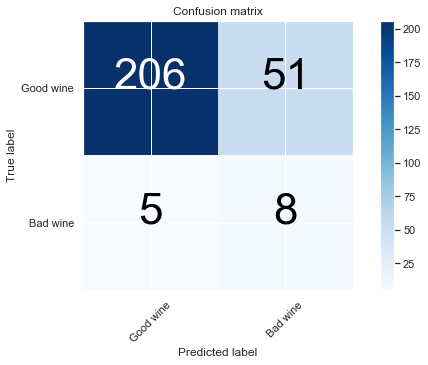

In [1038]:
plot_confusion_matrix(red_y_test, lr_gsv_y_pred_class_poly, ['Good wine','Bad wine'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [904]:
red_poly3 = PolynomialFeatures(degree=3, include_bias=False)
red_poly3.fit(red_X_train)
red_X_train_poly3= pd.DataFrame(red_poly3.transform(red_X_train), columns=red_poly3.get_feature_names(red_X_train.columns))
red_X_test_poly3= pd.DataFrame(red_poly3.transform(red_X_test), columns=red_poly3.get_feature_names(red_X_test.columns))
                               
red_columns_poly3 = red_poly3.get_feature_names(red_X_train.columns)


In [905]:
red_poly3_scalar = StandardScaler()

red_poly3_scalar.fit(red_X_train_poly3)
red_X_train_poly3_scaled  = pd.DataFrame(red_poly3_scalar.transform(red_X_train_poly3), columns=red_columns_poly3)
red_X_test_poly3_scaled  = pd.DataFrame(red_poly3_scalar.transform(red_X_test_poly3), columns=red_columns_poly3)

In [906]:
red_poly3_X_train_sm,red_poly3_y_train_sm = upSampleMinoritySMOTE(red_X_train_poly3_scaled, red_y_train)

1183 1183


In [907]:
lr_gsv_2.fit(red_poly3_X_train_sm,red_poly3_y_train_sm)
lr_gsv_y_pred_class_poly3 = lr_gsv_2.predict(red_X_test_poly3_scaled)
print('Classification Accuracy: ', metrics.accuracy_score(red_y_test, lr_gsv_y_pred_class_poly3))
print('Test F1 score: ', f1_score(red_y_test, lr_gsv_y_pred_class_poly3))
print(metrics.recall_score(red_y_test, lr_gsv_y_pred_class_poly3))

Classification Accuracy:  0.8703703703703703
Test F1 score:  0.14634146341463414
0.23076923076923078


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [910]:
# Create recursive feature eliminator that scores features by mean squared errors
lr_red_poly3_selector = RFECV(estimator=lr_gsv_2, step=1, cv=5, scoring='recall',n_jobs=-1)

# Fit recursive feature eliminator 
lr_red_poly3_selector.fit(red_X_train_poly3_scaled, red_y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
   min_features_to_select=1, n_jobs=-1, scoring='recall', step=1,
   verbose=0)

In [916]:
selected_columns = red_X_train_poly3_scaled.columns[lr_red_poly3_selector.support_]
removed_columns = red_X_train_poly3_scaled.columns[~lr_red_poly3_selector.support_]
list(removed_columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'sulphates',
 'bound_SO2',
 'adjusted_free_SO2',
 'abv_(10.0, 11.5]',
 'abv_(11.5, 14.0]',
 'molecular_SO2',
 'pH_(3.3, 3.6]',
 'pH_(3.6, 4.0]',
 'fixed acidity^2',
 'fixed acidity volatile acidity',
 'fixed acidity citric acid',
 'fixed acidity residual sugar',
 'fixed acidity chlorides',
 'fixed acidity free sulfur dioxide',
 'fixed acidity total sulfur dioxide',
 'fixed acidity density',
 'fixed acidity sulphates',
 'fixed acidity bound_SO2',
 'fixed acidity adjusted_free_SO2',
 'fixed acidity abv_(10.0, 11.5]',
 'fixed acidity abv_(11.5, 14.0]',
 'fixed acidity molecular_SO2',
 'fixed acidity pH_(3.3, 3.6]',
 'fixed acidity pH_(3.6, 4.0]',
 'volatile acidity^2',
 'volatile acidity citric acid',
 'volatile acidity residual sugar',
 'volatile acidity chlorides',
 'volatile acidity free sulfur dioxide',
 'volatile acidity total sulfur di

In [919]:
knn_gsv = KNeighborsClassifier()

In [924]:
knn_param_grid = { 
    'p': [1,2],
    'n_neighbors': range(1,8,2),
    'weights': ['uniform', 'distance']
}

In [926]:
CV_knn_gsv = GridSearchCV(knn_gsv, knn_param_grid, cv=5,n_jobs=-1)
CV_knn_gsv.fit(red_X_train_sm,red_y_train_sm)
### Identify the best params 
print(CV_knn_gsv.best_params_)

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


In [929]:
knn_gsv = KNeighborsClassifier(n_neighbors=1,p=2,weights='uniform')

knn_gsv.fit(red_X_train_sm, red_y_train_sm)

knn_gsv_y_pred_class = knn_gsv.predict(red_X_test)

print('Test Accuracy score: ', accuracy_score(red_y_test, knn_gsv_y_pred_class))
print('Test F1 score: ', f1_score(red_y_test, knn_gsv_y_pred_class))
print(metrics.recall_score(red_y_test, knn_gsv_y_pred_class))

Test Accuracy score:  0.9518518518518518
Test F1 score:  0.0
0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [930]:
lr_white_param_grid = { 
    'C': [.0001,.001,.01,.1,1],
    'class_weight': ['balanced'],
    'solver': ['liblinear', 'lbfgs']
}

In [931]:
CV_lr_white_gsv = GridSearchCV(lr_gsv, lr_white_param_grid, cv=5,n_jobs=-1)
CV_lr_white_gsv.fit(white_poly_X_train_sm,white_poly_y_train_sm)
### Identify the best params 
print(CV_lr_white_gsv.best_params_)

{'C': 1, 'class_weight': 'balanced', 'solver': 'liblinear'}


In [934]:
lr_white_poly_gsv = LogisticRegression(C=1,class_weight='balanced', solver='liblinear')

In [936]:
lr_white_poly_gsv.fit(white_poly_X_train_sm,white_poly_y_train_sm)
lr_white_gsv_y_pred_class_poly = lr_white_poly_gsv.predict(white_X_test_poly_scaled)
print('Classification Accuracy: ', metrics.accuracy_score(white_y_test, lr_white_gsv_y_pred_class_poly))
print('Test F1 score: ', f1_score(white_y_test, lr_white_gsv_y_pred_class_poly))
print(metrics.recall_score(white_y_test, lr_white_gsv_y_pred_class_poly))

Classification Accuracy:  0.8457648546144121
Test F1 score:  0.2469135802469136
0.6666666666666666


In [1011]:
CV_lr_poly_white_gsv = GridSearchCV(lr_gsv, lr_white_param_grid, cv=50,n_jobs=-1)
CV_lr_poly_white_gsv.fit(white_poly_X_train_sm_2,white_poly_y_train_sm_2)
### Identify the best params 
print(CV_lr_poly_white_gsv.best_params_)

{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## FINAL WHITE

In [1012]:
lr_white_poly2_gsv = LogisticRegression(C=0.1,class_weight='balanced', solver='lbfgs')

In [1013]:
lr_white_poly2_gsv.fit(white_poly_X_train_sm_2,white_poly_y_train_sm_2)
lr_white_gsv_y_pred_class_poly2 = lr_white_poly2_gsv.predict(white_X_test_poly_2)
print('Classification Accuracy: ', metrics.accuracy_score(white_y_test, lr_white_gsv_y_pred_class_poly2))
print('Test F1 score: ', f1_score(white_y_test, lr_white_gsv_y_pred_class_poly2))
print(metrics.recall_score(white_y_test, lr_white_gsv_y_pred_class_poly2))

Classification Accuracy:  0.8305941845764855
Test F1 score:  0.23863636363636362
0.7


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Confusion Matrix, without normalization
[[636 125]
 [  9  21]]


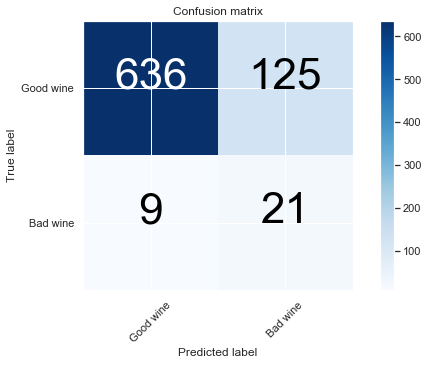

In [1044]:
plot_confusion_matrix(white_y_test, lr_white_gsv_y_pred_class_poly2, ['Good wine','Bad wine'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [94]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA